In [1]:
"""
Import libraries: 
Keras, CV2, Matplotlib, Numpy
"""

import keras
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D,Concatenate,Convolution2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import cv2


Using TensorFlow backend.


In [2]:
"""
Function to convert RGB to LAB.
Input: image in RGB format with full values for pixels. (0-255)
Output: image in LAB format and with all values between -1 and 1.
"""


def rgb_to_lab(image, l=False, ab=False):
     
    image = image.astype('uint8')
    l_channel = (cv2.cvtColor((image),cv2.COLOR_RGB2LAB))[:,:,0]
    l_channel = (l_channel / 255) *2 - 1
    l_channel = l_channel[...,np.newaxis]

    ab_channels = (cv2.cvtColor((image),cv2.COLOR_RGB2LAB))[:,:,1:]
    ab_channels = (ab_channels/255)* 2 - 1
    if l:
        return l_channel
    else: 
        return ab_channels

In [3]:
"""
Load dataset and convert RGB to LAB colorspace using rgb_to_lab()
"""

(X_main_train, y_train), (X_main_test, y_test) = cifar10.load_data()

# Model is designed only to colorize ships. Therefore only images with label 8(ships in cifar10) are used.
X_train_temp = np.array([X_main_train[i] for i in range(len(y_train)) if y_train[i] == 8])
X_test_temp = np.array([X_main_test[i] for i in range(len(y_test)) if y_test[i] == 8])

#Separate all images in training and test set into L and AB components after converting RGB to LAB colorspace.
X_train_L = np.array([rgb_to_lab(image, l=True) for image in X_train_temp]).astype('float32')
X_train_AB = np.array([rgb_to_lab(image, ab=True) for image in X_train_temp]).astype('float32')
X_test_L = np.array([rgb_to_lab(image,l=True) for image in X_test_temp]).astype('float32')
X_test_AB = np.array([rgb_to_lab(image, ab=True) for image in X_test_temp]).astype('float32')

print("Training and Test data ready!!")

170500096/170498071 [==============================] - 699s 4us/step
Training and Test data ready!!


In [4]:
"""
Design the generator and discriminator networks. 
Generator: Use LeakyRELU for Input layer and Hidden layers, tanh for output layer 
           (output values from [-1,1] for AB)
Discriminator: Use LeakyRELU for Input layer and Hidden layers, sigmoid for output layer 
            (output values from [0,1] to classify as real or fake)
"""
def generator_nn():
    activation=LeakyReLU(alpha=0.2)
    generator_input = Input(shape=(32,32,1))

    conv1 = Conv2D(32, (3, 3), padding='same', strides=1)(generator_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = activation(conv1)

    conv2 = Conv2D(64, (3, 3), padding='same', strides=2)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = (activation)(conv2)

    conv3 = Conv2D(128, (3, 3), padding='same', strides=2)(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = (activation)(conv3)

    conv4 = UpSampling2D(size=(2, 2))(conv3)
    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = (activation)(conv4)
    conv4 = Concatenate(axis=-1)([conv2,conv4])

    conv5 = UpSampling2D(size=(2, 2))(conv4)
    conv5 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = (activation)(conv5)
    conv5 = Concatenate(axis=-1)([conv1,conv5])

    conv6 = Conv2D(16, (3, 3), padding='same', strides=1)(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = (activation)(conv6)

    conv7 = Conv2D(2, (3, 3), padding='same', strides=1)(conv6)
    conv7 = Activation('tanh')(conv7)

    model = Model(inputs=generator_input,outputs=conv7)
    return model

def discriminator_nn():
    activation=LeakyReLU(alpha=0.2)
    discriminator_input = Input(shape=(32,32,2))
    model = Sequential()
    model.add(Conv2D(32,(3, 3), padding='same', input_shape=(32,32,2),strides=2))
    model.add(activation)

    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same',strides=1))
    model.add(BatchNormalization())
    model.add(activation)
    model.add(Dropout(.25))

    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model



In [5]:
"""
Generate the generator, discriminator and their combined model and compile them.
"""

g_input_shape = (32,32,1)
d_input_shape = (32,32,2)

#Compile Generator network

generator = generator_nn()
opt = Adam(lr=.001)
generator.compile(loss='binary_crossentropy', optimizer=opt , metrics=['accuracy'])
print('Generator Summary...')
print(generator.summary())

#Compile Discriminator network

discriminator = discriminator_nn()
opt = Adam(lr=.0001)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print('Discriminator Summary...')
print(discriminator.summary())

#Combine generator and discriminator into one model. 
#Set trainable parameter of discriminator to false and compile the combined model.

gan_input = Input(shape=g_input_shape)
img_color = generator(gan_input)
discriminator.trainable = False
real_or_fake = discriminator(img_color)
gan = Model(gan_input,real_or_fake)
opt = Adam(lr=.001)
gan.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])

print('\n GAN summary...')
print(gan.summary())

Generator Summary...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       multiple             0           batch_normalization_1[0][0]      
                                                                 batch_normalization_2[0

In [6]:
"""
Initialize python lists to store training history.
Create numpy arrays: y_train_fake and y_train_real to train discriminator.
"""
g_losses = []
g_acc=[]
d_losses = []
d_acc = []
X_train = X_train_L
n = len(X_train)
count=1
y_train_fake = np.zeros([n,1])
y_train_real = np.ones([n,1])


In [7]:
"""
Function to train model
"""

def train_nn(epoch):
    global count
    for e in range(epoch):
        print("________________________________________________________EPOCH: ", count)
        
        #Generate Images
        np.random.shuffle(X_train)
        generated_images = generator.predict(X_train, verbose=1)
        
        #Train discriminator with real images to classify as real
        np.random.shuffle(X_train_AB)
        d_loss  = discriminator.fit(x=X_train_AB, y=y_train_real,  batch_size=16, epochs=1)
        print("Discriminator_1 ---- ",count)
        
        #Train discrimnator with noisy/fake images every three epochs to classify as fake
        if e % 3 == 2:
            noise = np.random.rand(n,32,32,2) * 2 -1
            d_loss =discriminator.fit(x=noise, y=y_train_fake, batch_size=16, epochs=1)
            print("Discriminator_2 ---- ",count)
            
        #Train discrimnator with generated images from generator to classify as fake
        d_loss = discriminator.fit(x=generated_images, y=y_train_fake, batch_size=16, epochs=1)
        print("Discriminator_3 ---- ",count)
        
        #Record discriminator results
        d_losses.append(d_loss.history['loss'][-1])
        d_acc.append(d_loss.history['acc'][-1])
        print('d_loss:', d_loss.history['loss'][-1])
        
        #Train generator within the combined network
        g_loss =gan.fit(x=X_train, y=y_train_real, batch_size=16, epochs=1)
        print("GAN ---- ",count)
        
        #Record results
        g_losses.append(g_loss.history['loss'][-1])
        g_acc.append(g_loss.history['acc'][-1])
        print('GAN Loss: ', g_loss.history['loss'][-1])
        print('GAN Accuracy: ', g_loss.history['acc'][-1])
        
        #Increment total epoch count
        count=count+1
        
        #Print result for every epoch
        view_result(120)

In [35]:
"""
Function to convert LAB output to RGB and display
Input: Index of image in dataset to colorize.

"""

def view_result(index):
    
    #Load image from dataset
    image=np.array(X_test_temp[index])
    
    #Form figure
    f = plt.figure(figsize=(20, 10))
    
    #Plot original color image
    f.add_subplot(1,3,1)
    plt.imshow(image)
    
    #Extract L component(grayscale) after converting RGB to LAB and plot grayscale image
    L = (cv2.cvtColor((image),cv2.COLOR_RGB2LAB))[:,:,0]
    f.add_subplot(1,3,2)
    plt.imshow(L.reshape(32,32),cmap='gray')
    
    #Colorize image by passing grayscale image through the model, convert resulting LAB output to RGB and plot.   
    L=(L.reshape(1,32,32,1))/255*2-1
    AB=g_test.predict(L)
    AB=AB.reshape(32,32,2)
    AB=(AB+1) / 2 * 255 
    L=L.reshape(32,32,1)
    result=np.concatenate((L,AB),axis=2)
    result=result.astype('uint8')
    g_c =cv2.cvtColor((result),cv2.COLOR_LAB2RGB)
    f.add_subplot(1,3,3)
    plt.imshow(g_c)
    
      

________________________________________________________EPOCH:  1
5000/5000 [==============================] - 107s 21ms/step


C:\Users\CUSTOMS\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/1
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0703 - acc: 0.9906
Discriminator_1 ----  1
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2144 - acc: 0.9162
Discriminator_3 ----  1
d_loss: 0.21440478507988156
Epoch 1/1
5000/5000 [==============================] - 450s 90ms/step - loss: 0.0868 - acc: 0.9816
GAN ----  1
GAN Loss:  0.08684885517135263
GAN Accuracy:  0.9816
________________________________________________________EPOCH:  2
5000/5000 [==============================] - 108s 22ms/step
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1275 - acc: 0.9554: 
Discriminator_1 ----  2
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 2.1830 - acc: 0.8450
Discriminator_3 ----  2
d_loss: 2.1829948096852814
Epoch 1/1
5000/5000 [==============================] - 358s 72ms/step - loss: 0.0711 - acc: 0.9916
GAN ----  2
GAN Loss:  0.07106328356759622
GAN Accuracy:  0.9916
_____

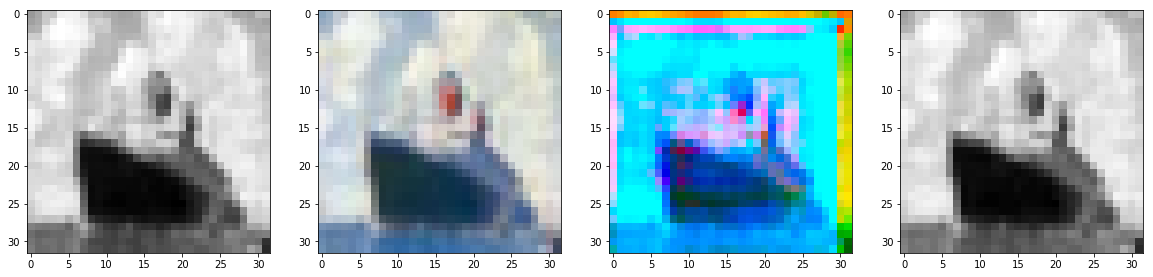

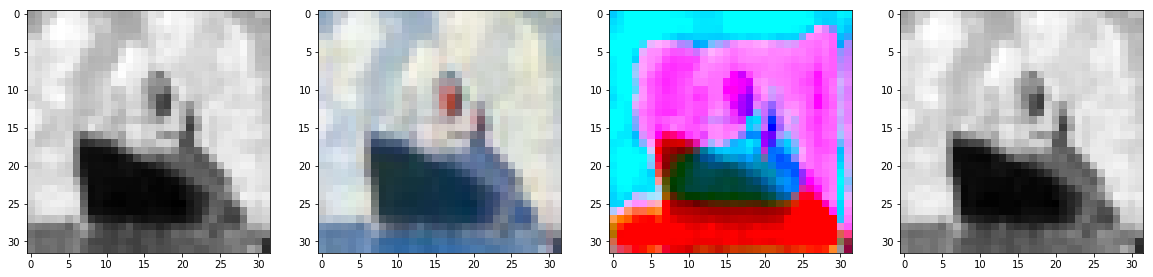

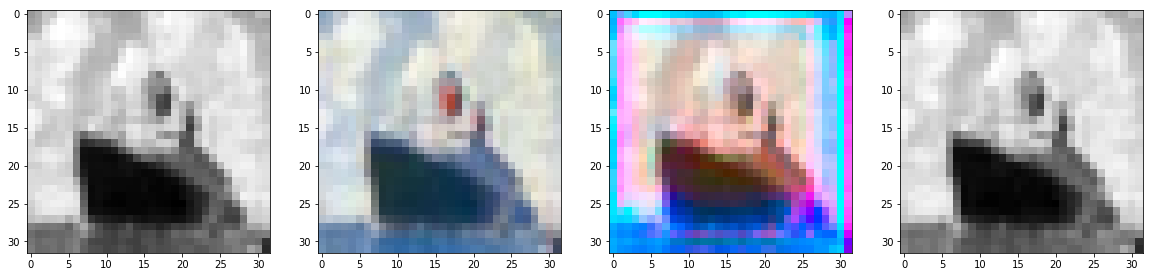

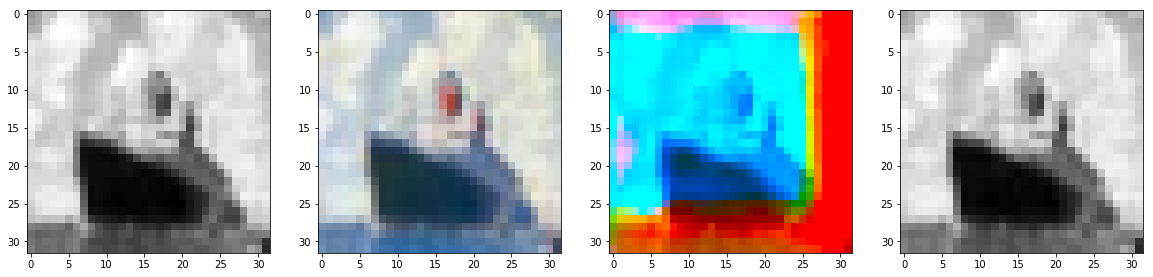

In [9]:
train_nn(4)


________________________________________________________EPOCH:  5
5000/5000 [==============================] - 73s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0454 - acc: 0.9886A
Discriminator_1 ----  5
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.1638 - acc: 0.9722
Discriminator_3 ----  5
d_loss: 0.16378341316900988
Epoch 1/1
5000/5000 [==============================] - 316s 63ms/step - loss: 0.1301 - acc: 0.9814
GAN ----  5
GAN Loss:  0.1300870644338429
GAN Accuracy:  0.9814
________________________________________________________EPOCH:  6
5000/5000 [==============================] - 74s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0294 - acc: 0.9952
Discriminator_1 ----  6
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2143 - acc: 0.9674
Discriminator_3 ----  6
d_loss: 0.21432243225623024
Epoch 1/1
5000/5000 [=============================

C:\Users\CUSTOMS\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


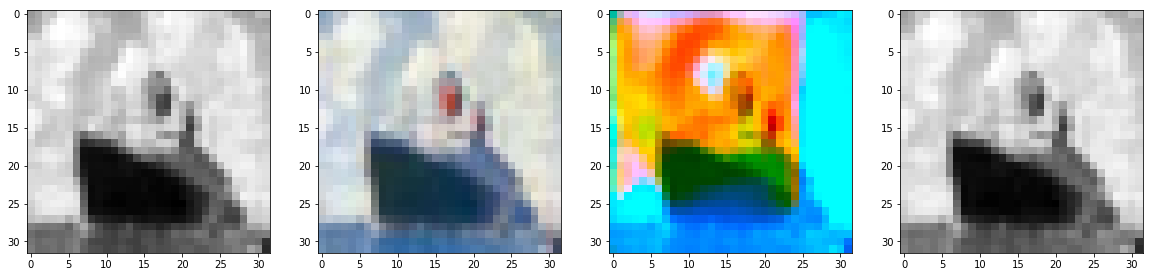

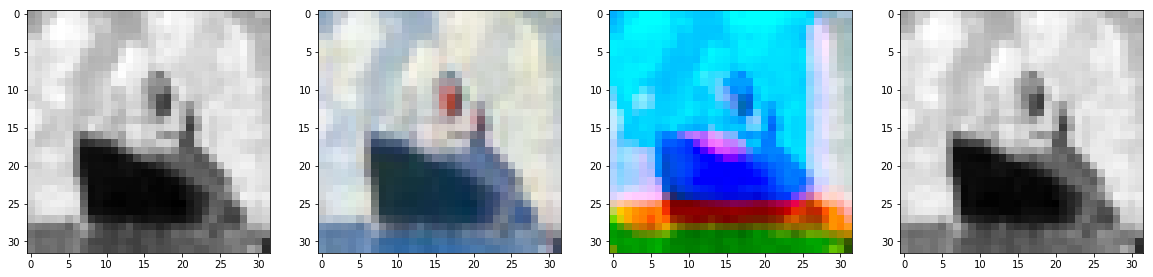

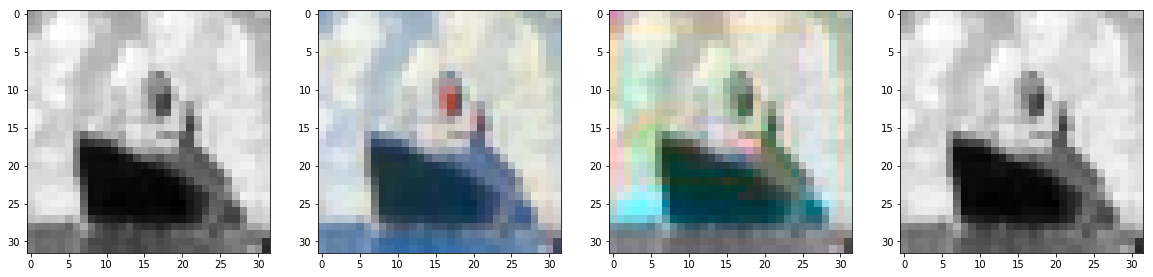

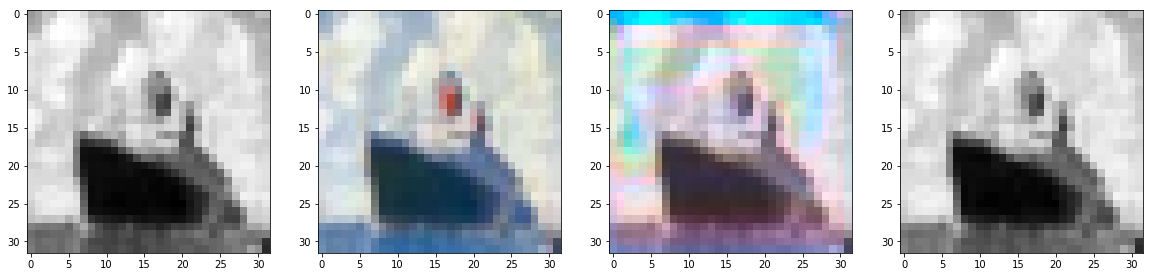

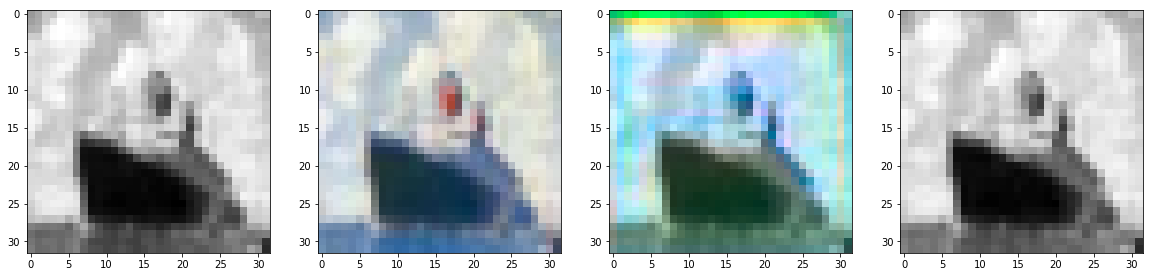

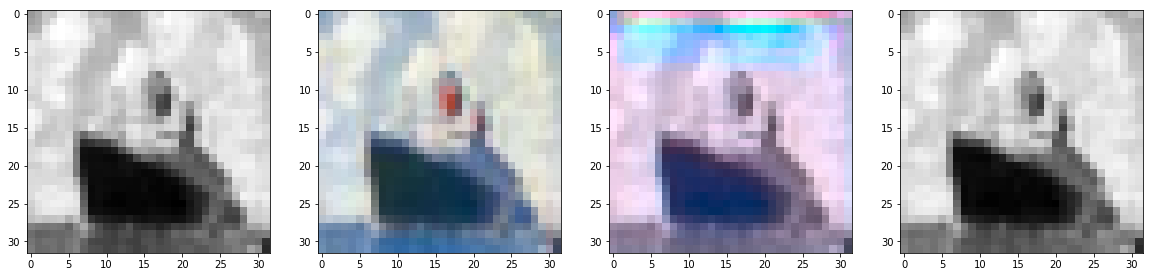

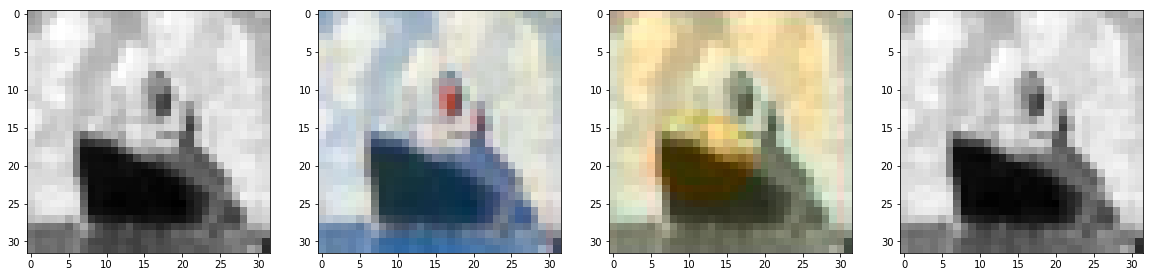

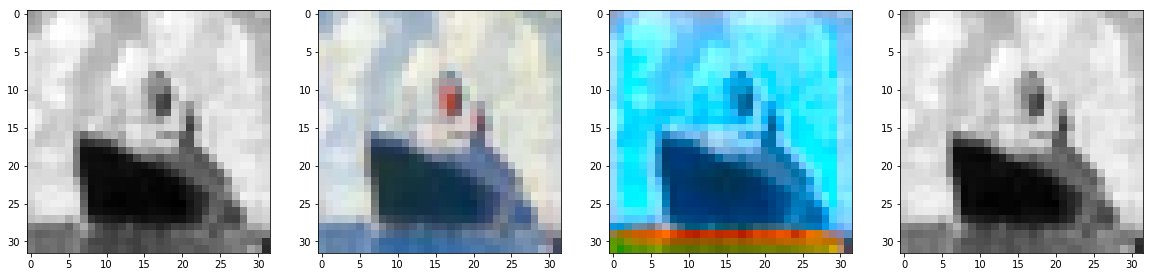

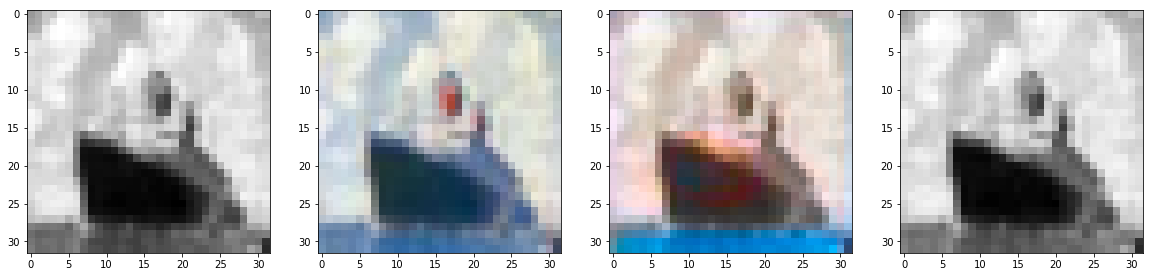

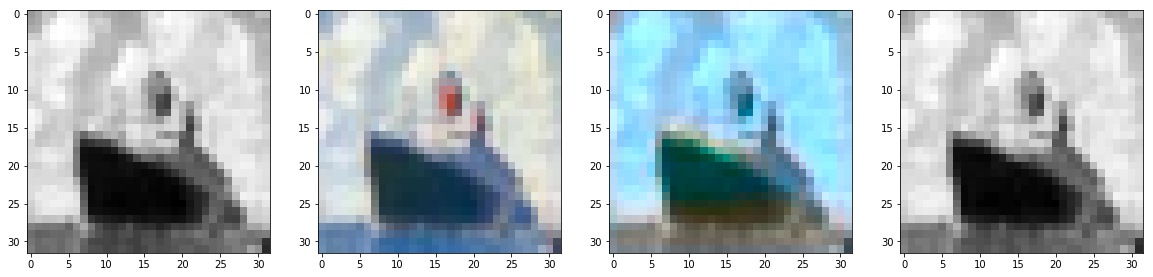

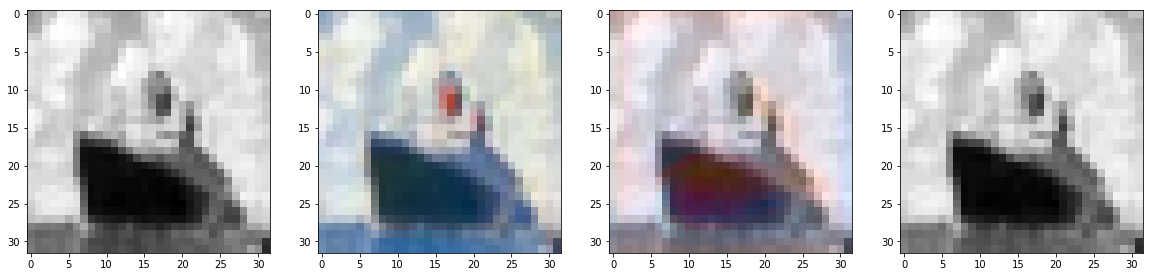

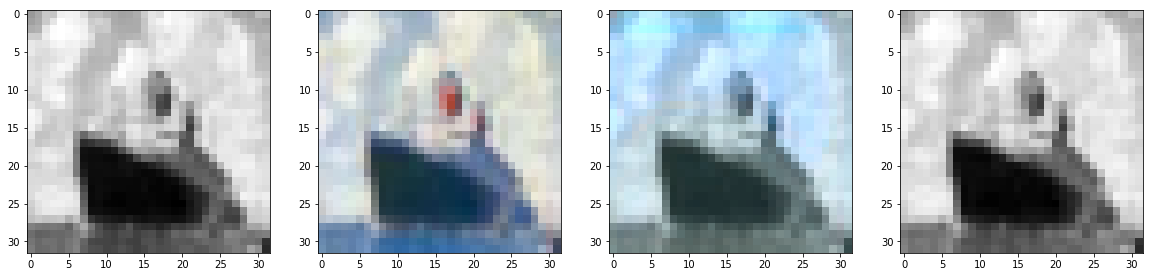

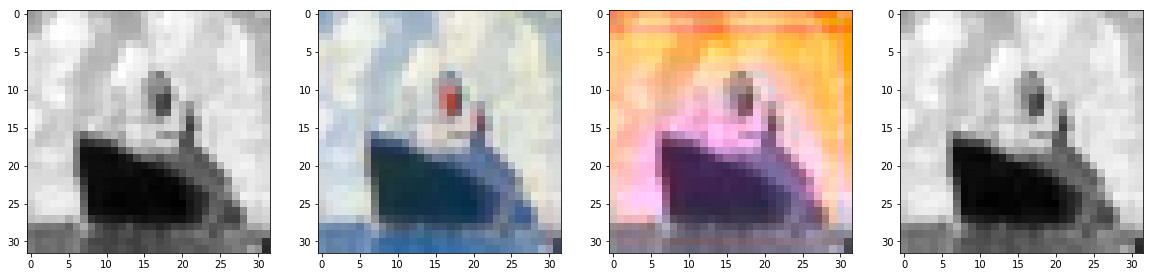

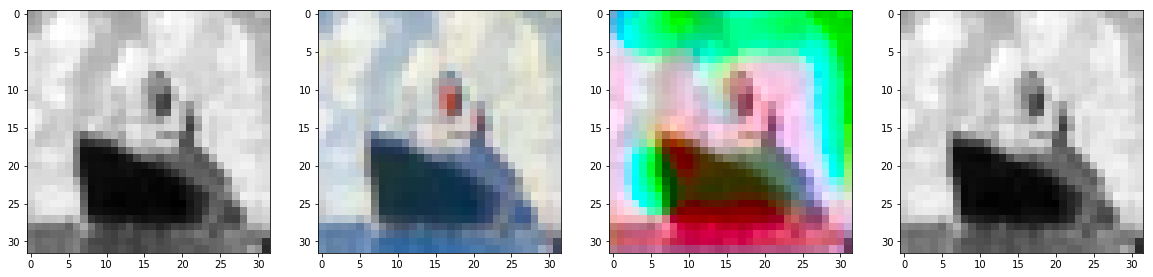

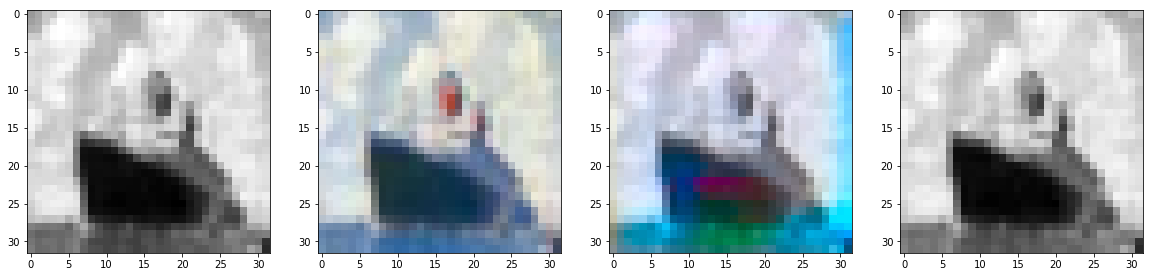

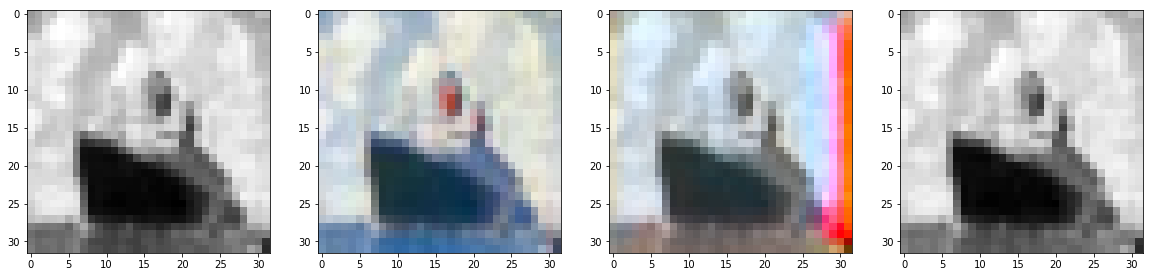

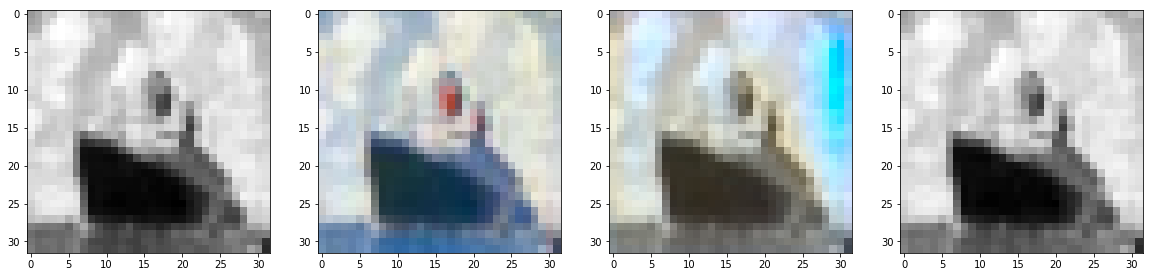

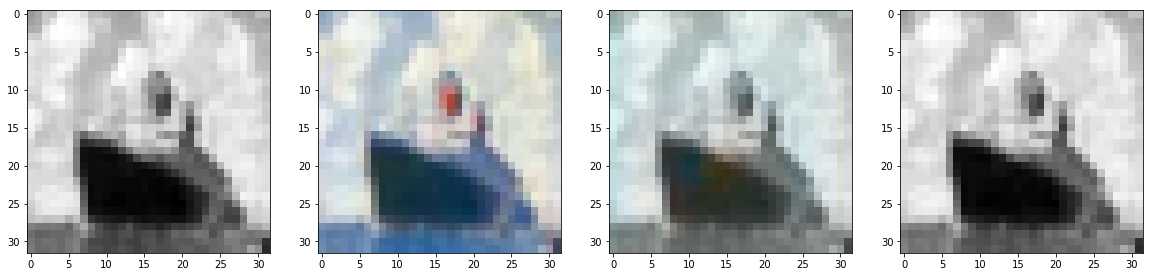

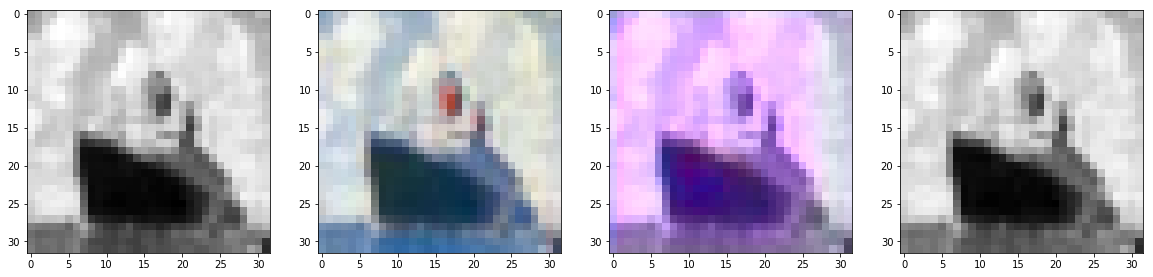

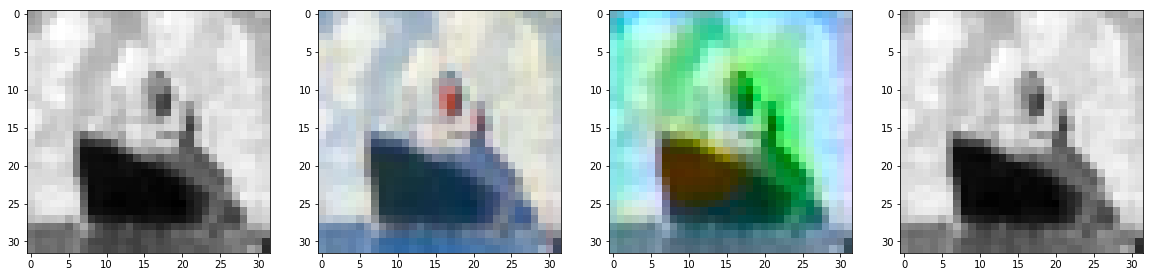

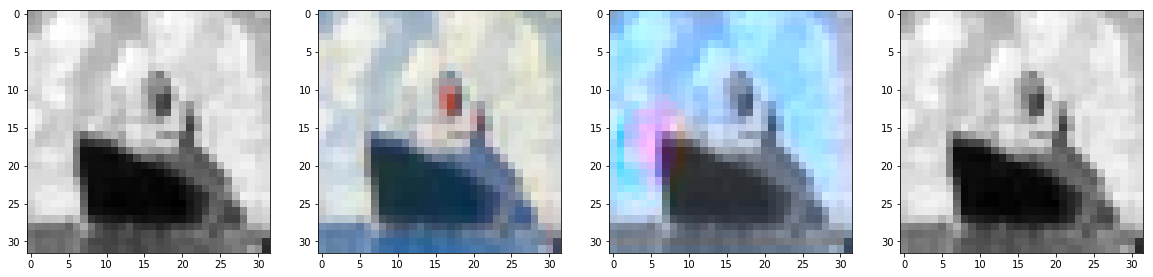

In [10]:
train_nn(21)


________________________________________________________EPOCH:  26
5000/5000 [==============================] - 76s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0355 - acc: 0.9922
Discriminator_1 ----  26
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2297 - acc: 0.9400
Discriminator_3 ----  26
d_loss: 0.22965076968818904
Epoch 1/1
5000/5000 [==============================] - 304s 61ms/step - loss: 0.4990 - acc: 0.8666
GAN ----  26
GAN Loss:  0.49898192892074583
GAN Accuracy:  0.8666
________________________________________________________EPOCH:  27
5000/5000 [==============================] - 73s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.1317 - acc: 0.9584
Discriminator_1 ----  27
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.1370 - acc: 0.9550
Discriminator_3 ----  27
d_loss: 0.13697199254669248
Epoch 1/1
5000/5000 [======================

5000/5000 [==============================] - 302s 60ms/step - loss: 0.3960 - acc: 0.9294
GAN ----  52
GAN Loss:  0.3959525755286217
GAN Accuracy:  0.9294
________________________________________________________EPOCH:  53
5000/5000 [==============================] - 73s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0954 - acc: 0.9702
Discriminator_1 ----  53
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.1513 - acc: 0.9508
Discriminator_3 ----  53
d_loss: 0.15131919644456357
Epoch 1/1
5000/5000 [==============================] - 302s 60ms/step - loss: 0.2280 - acc: 0.9474
GAN ----  53
GAN Loss:  0.22795902887582778
GAN Accuracy:  0.9474
________________________________________________________EPOCH:  54
5000/5000 [==============================] - 73s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0427 - acc: 0.9924
Discriminator_1 ----  54
Epoch 1/1
5000/5000 [=================

5000/5000 [==============================] - 303s 61ms/step - loss: 0.3722 - acc: 0.9294
GAN ----  79
GAN Loss:  0.37223421741724017
GAN Accuracy:  0.9294
________________________________________________________EPOCH:  80
5000/5000 [==============================] - 73s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0768 - acc: 0.9736
Discriminator_1 ----  80
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0479 - acc: 0.9774ETA: 1s - loss: 0.0585 - acc: 0.9 - ETA: 1s - loss: 0.0570 - ac - ETA: 0s - loss: 0.0525 -
Discriminator_3 ----  80
d_loss: 0.04790930116684176
Epoch 1/1
5000/5000 [==============================] - 304s 61ms/step - loss: 0.1762 - acc: 0.9626
GAN ----  80
GAN Loss:  0.17621823929548264
GAN Accuracy:  0.9626
________________________________________________________EPOCH:  81
5000/5000 [==============================] - 73s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step -

5000/5000 [==============================] - 8s 2ms/step - loss: 0.1757 - acc: 0.9564
Discriminator_1 ----  93
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.1490 - acc: 0.9656A: 1s 
Discriminator_3 ----  93
d_loss: 0.14901053802482783
Epoch 1/1
5000/5000 [==============================] - 304s 61ms/step - loss: 0.1793 - acc: 0.9696
GAN ----  93
GAN Loss:  0.17930630245096982
GAN Accuracy:  0.9696
________________________________________________________EPOCH:  94
5000/5000 [==============================] - 74s 15ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0297 - acc: 0.9956
Discriminator_1 ----  94
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0013 - acc: 0.9998
Discriminator_2 ----  94
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2509 - acc: 0.9570
Discriminator_3 ----  94
d_loss: 0.25088594705577705
Epoch 1/1
5000/5000 [==============================]

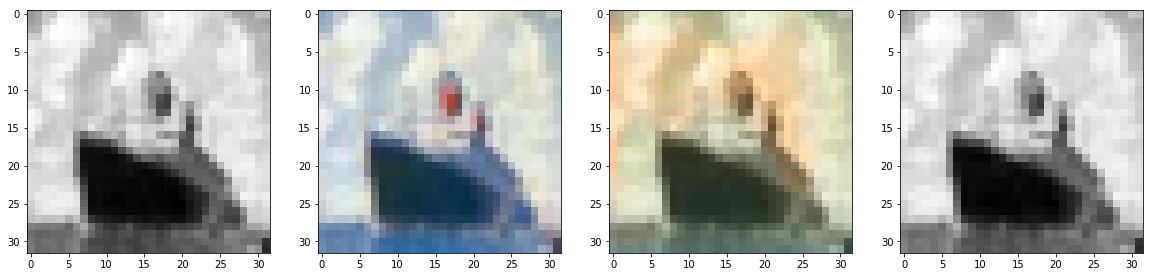

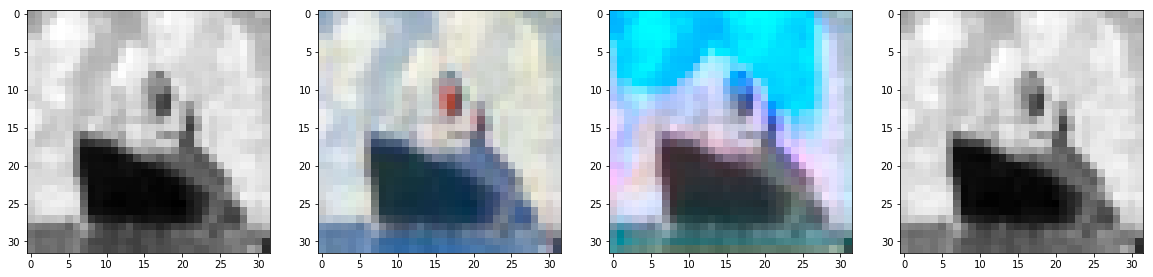

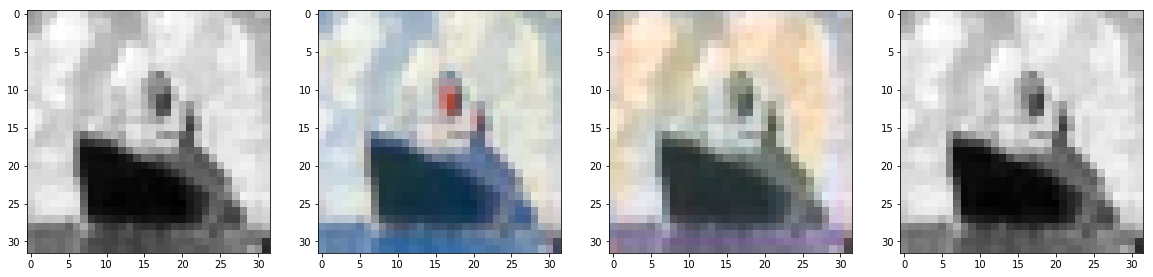

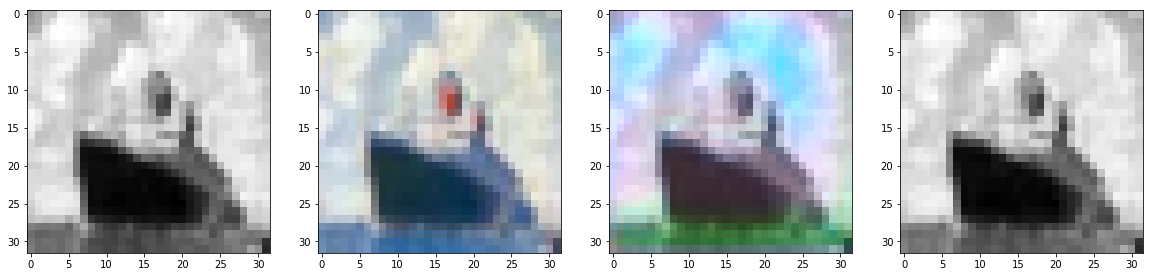

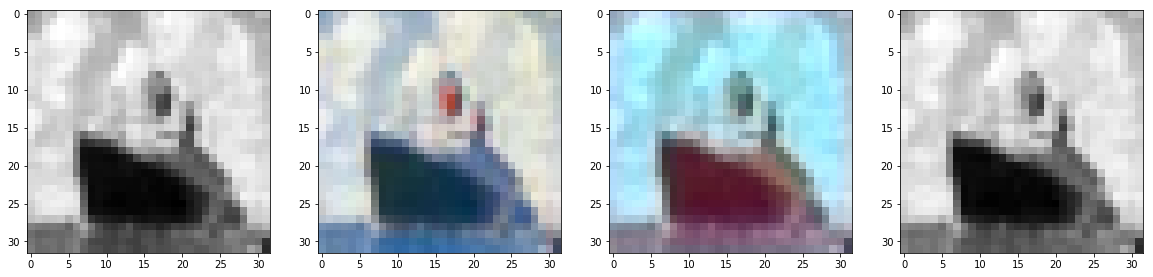

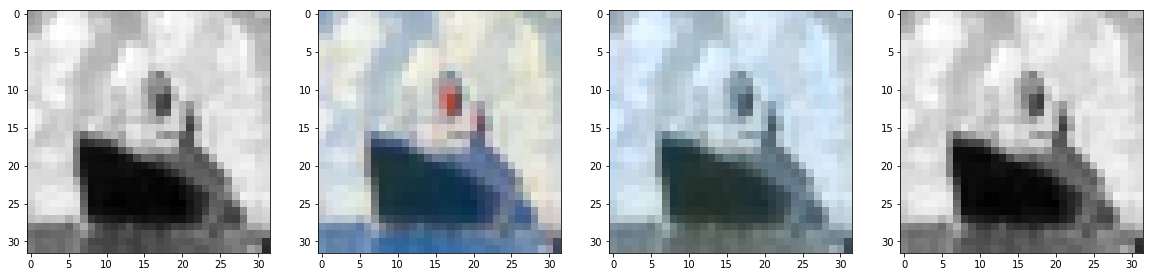

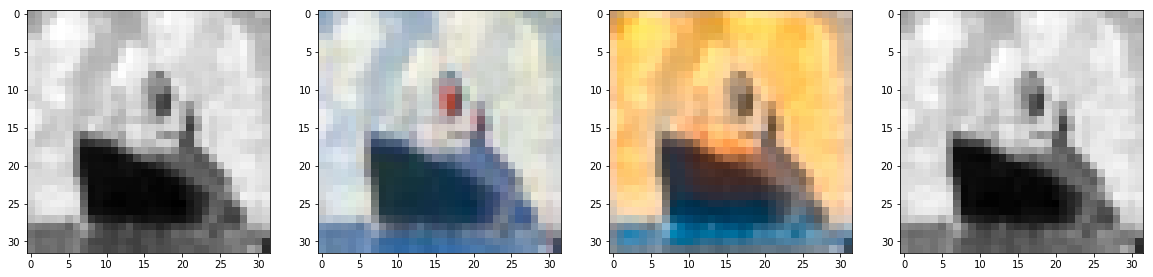

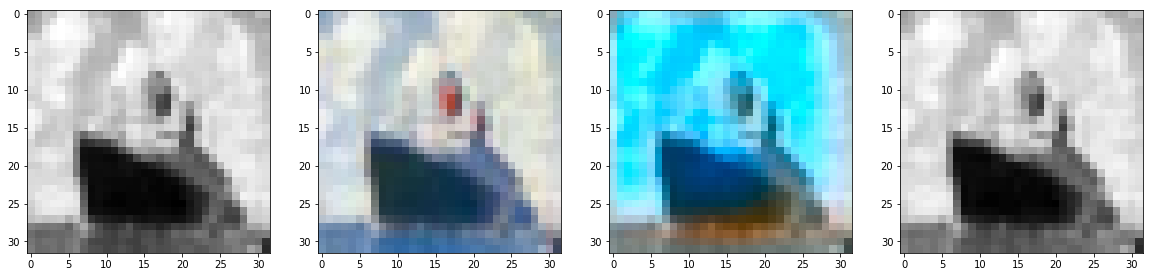

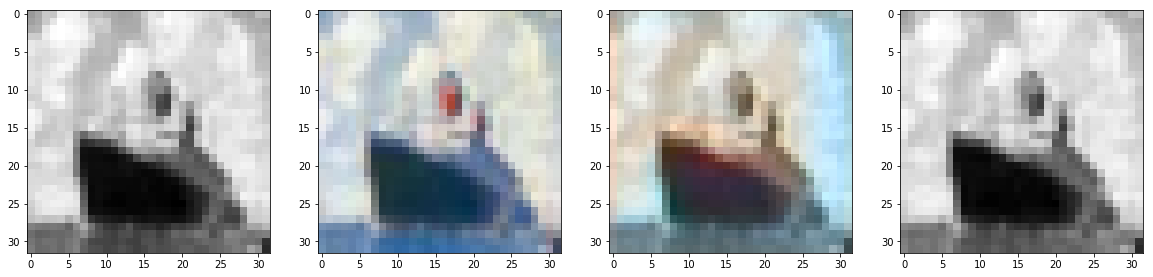

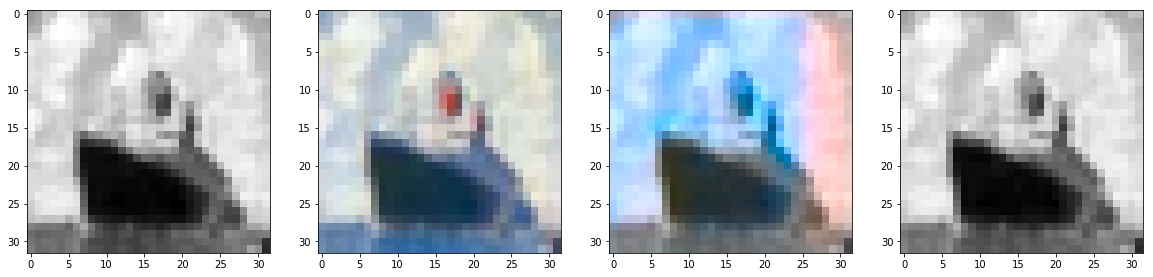

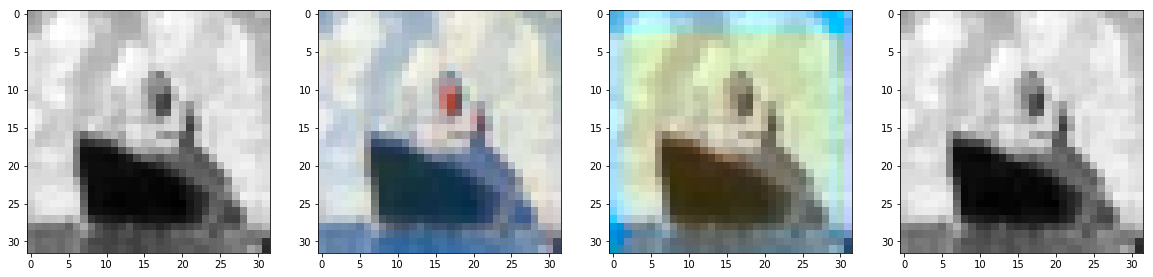

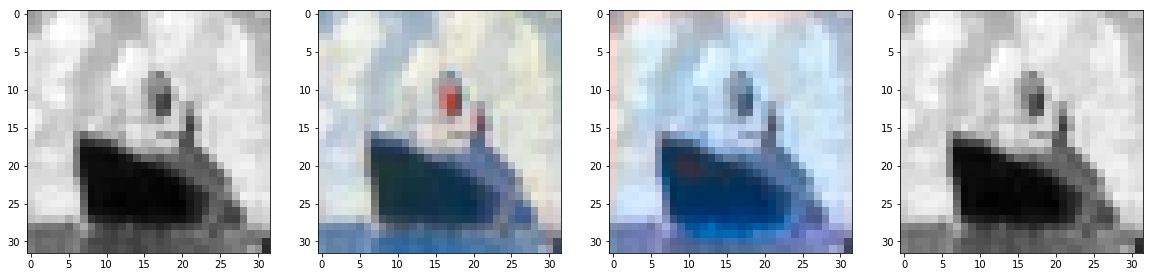

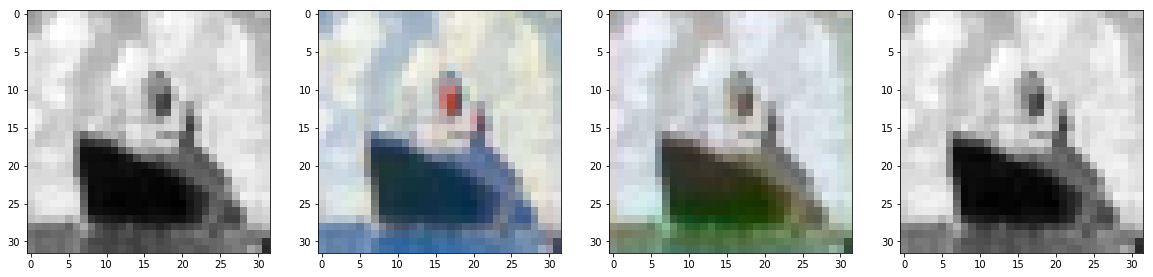

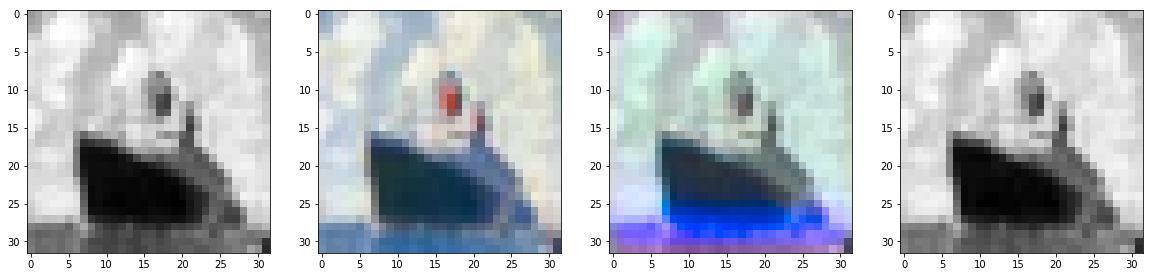

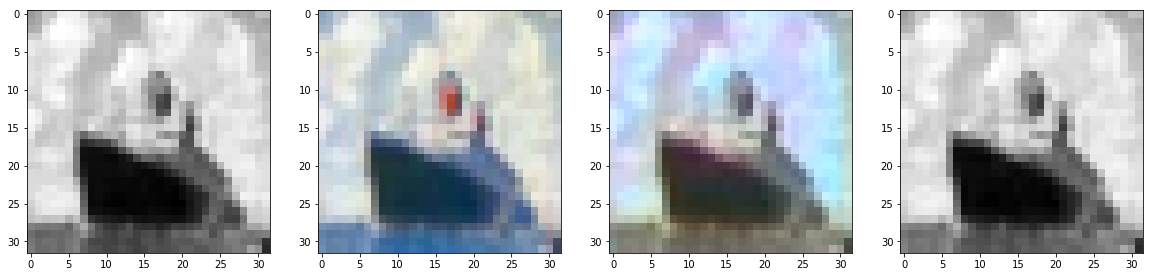

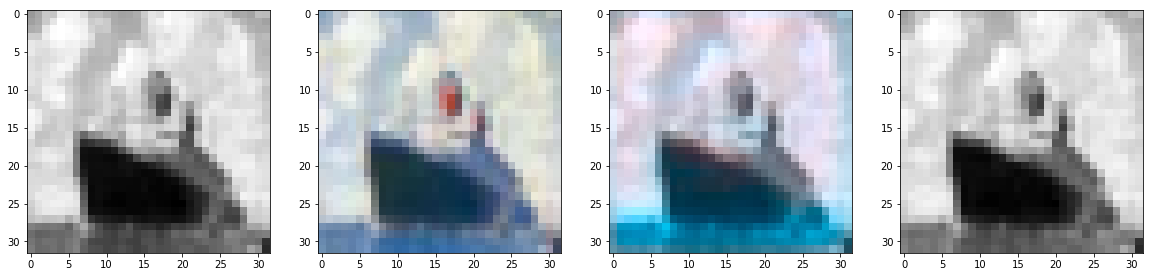

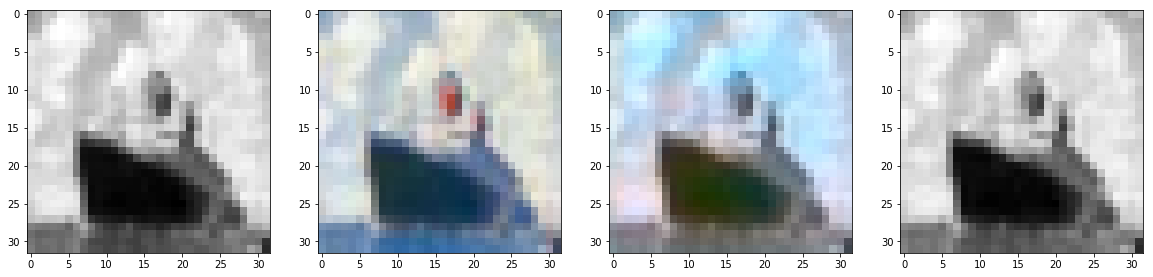

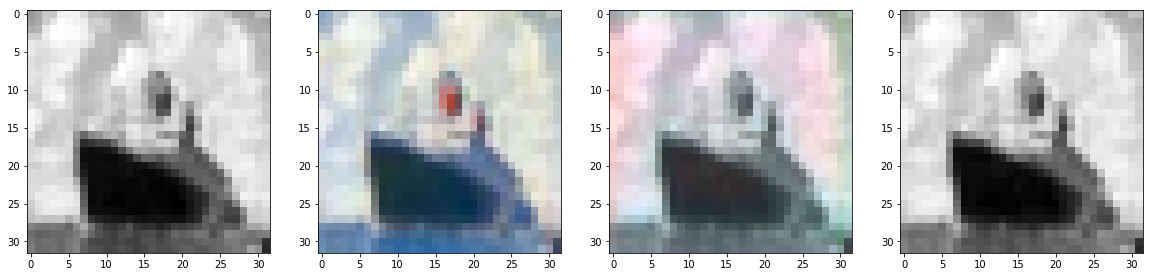

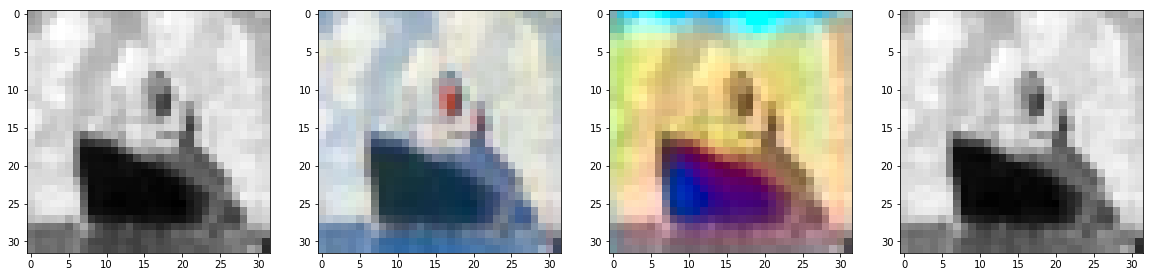

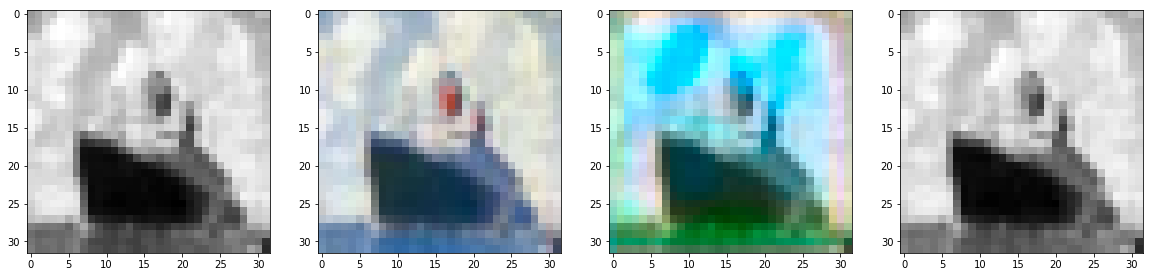

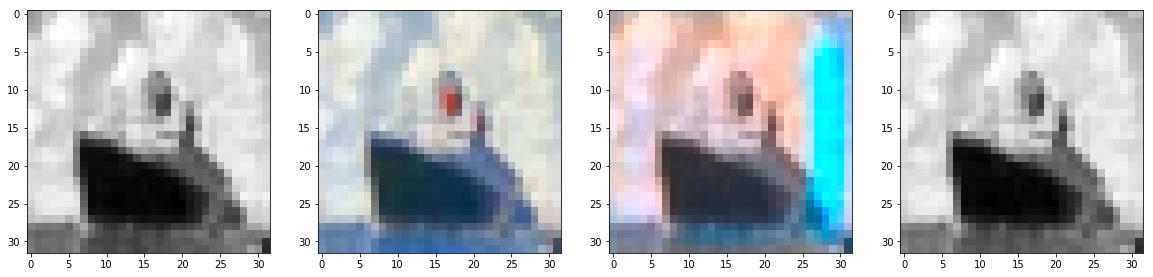

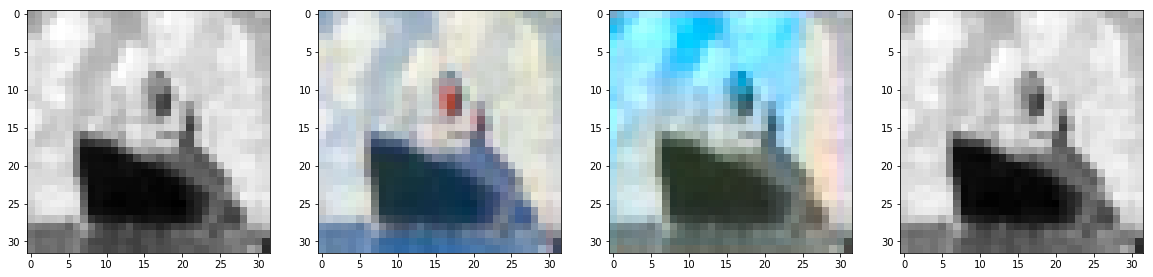

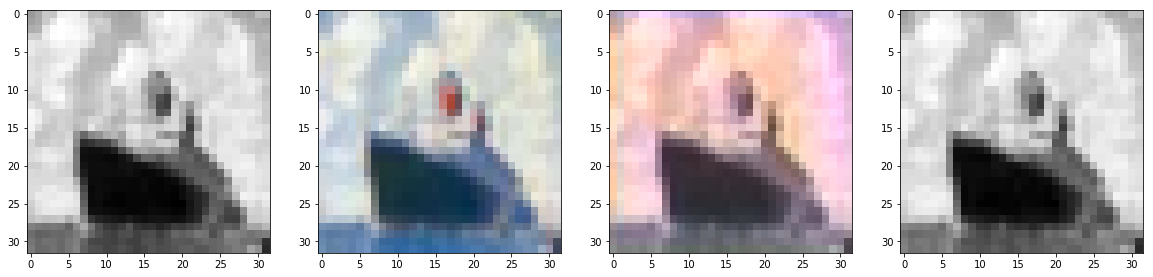

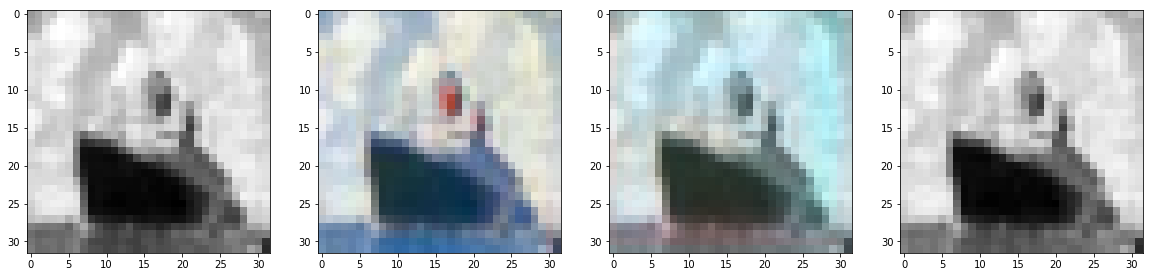

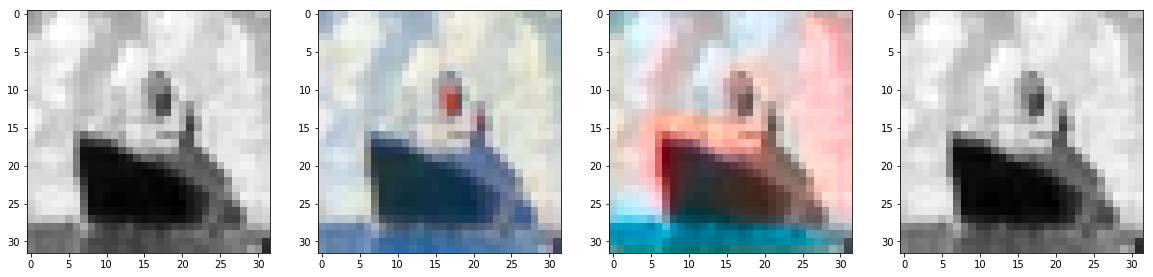

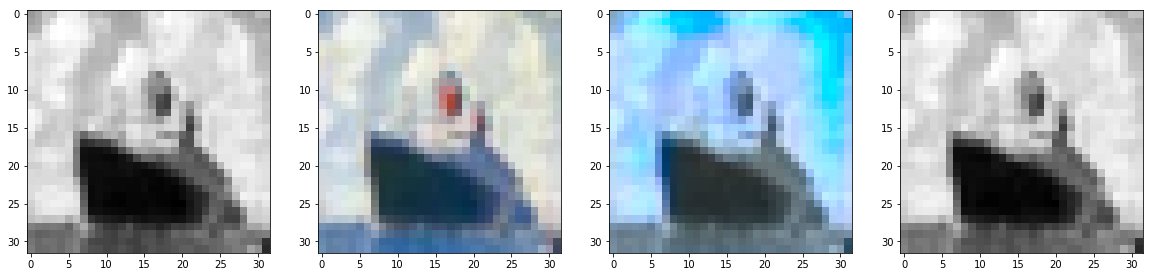

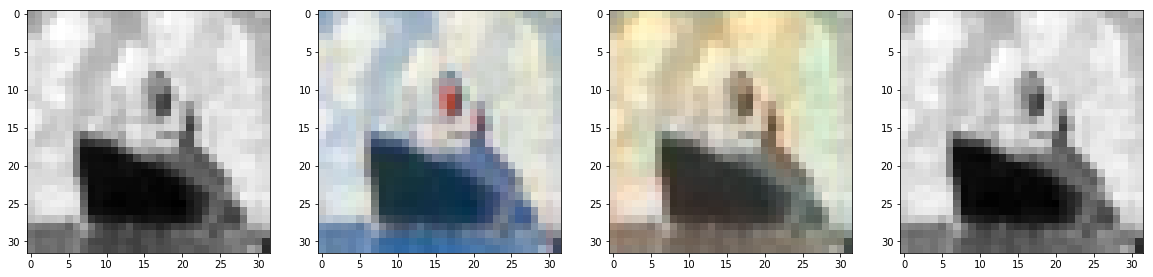

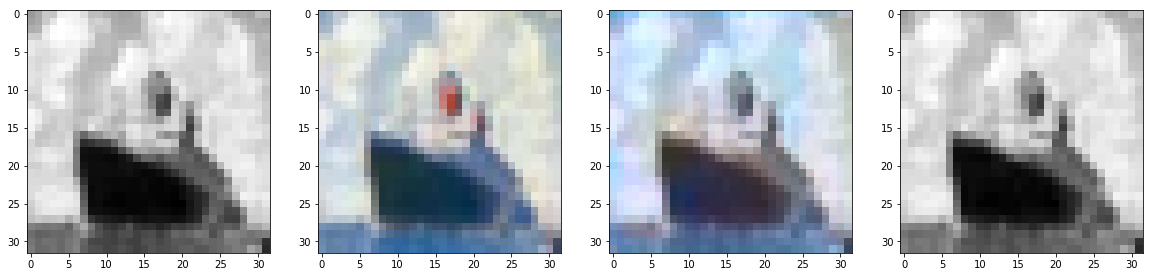

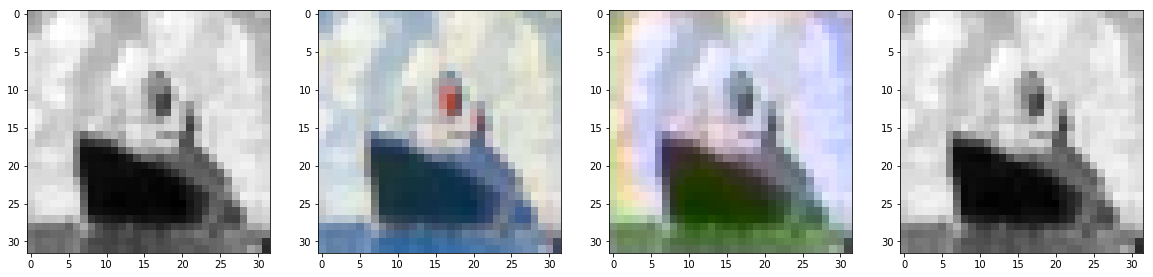

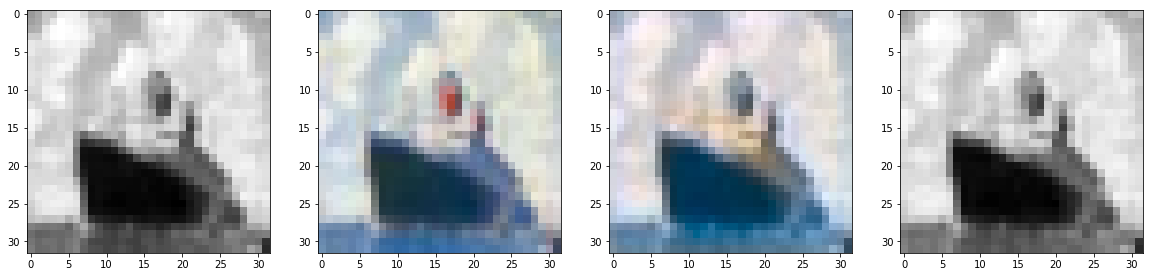

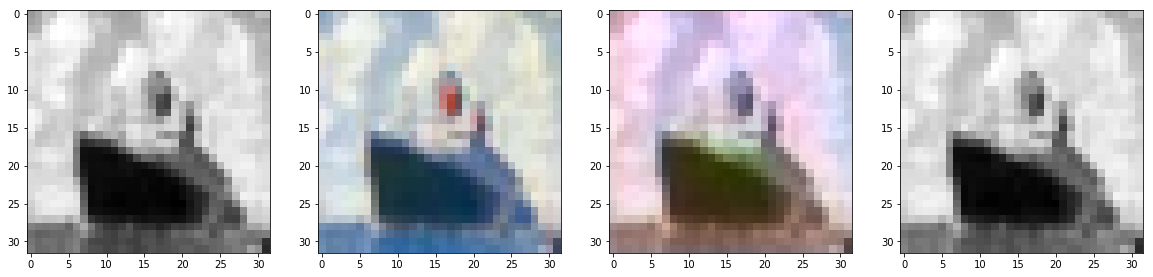

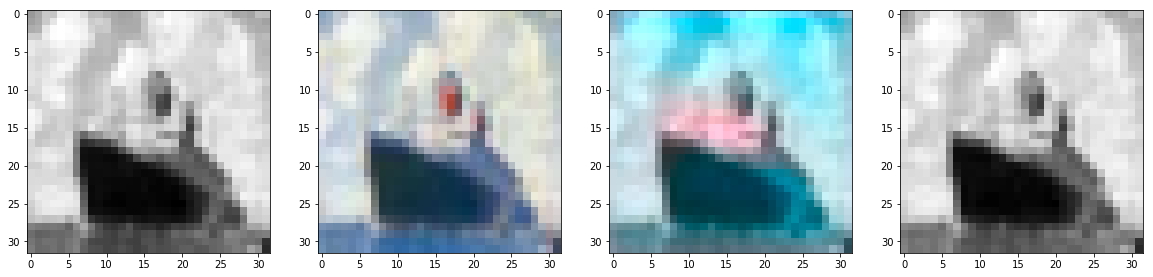

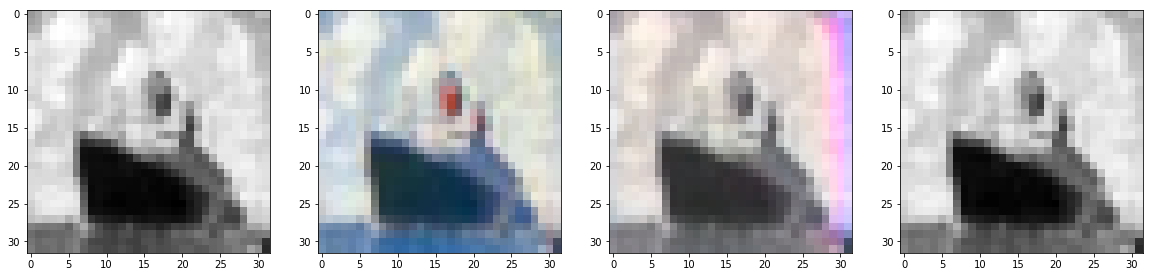

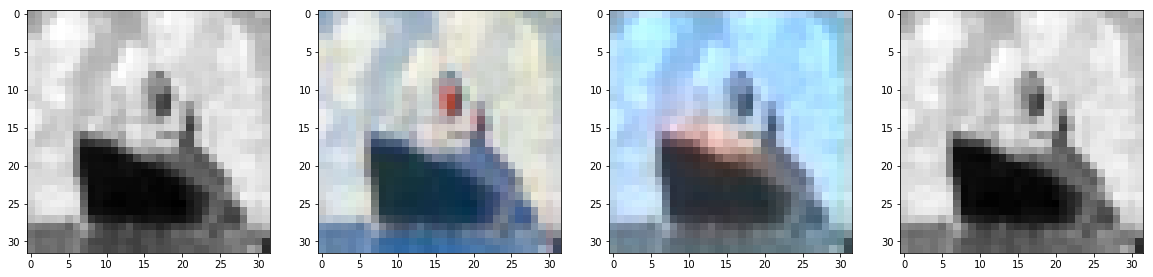

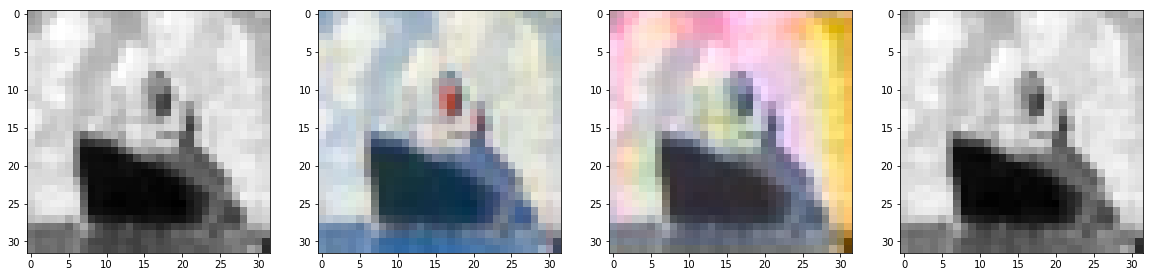

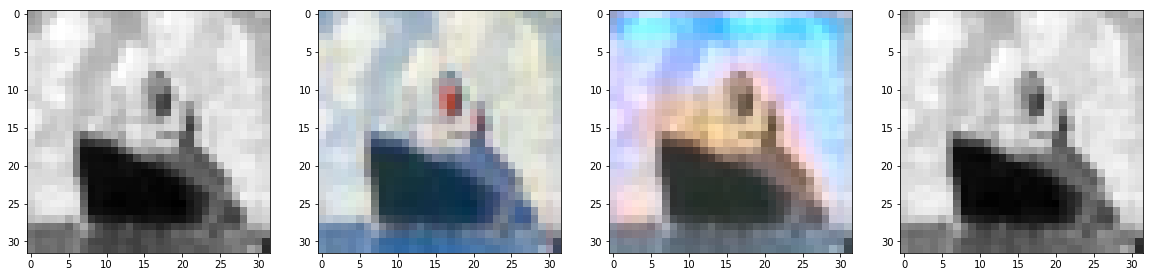

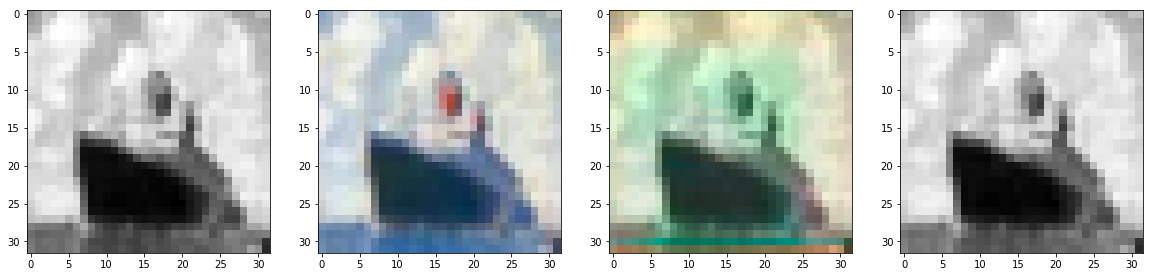

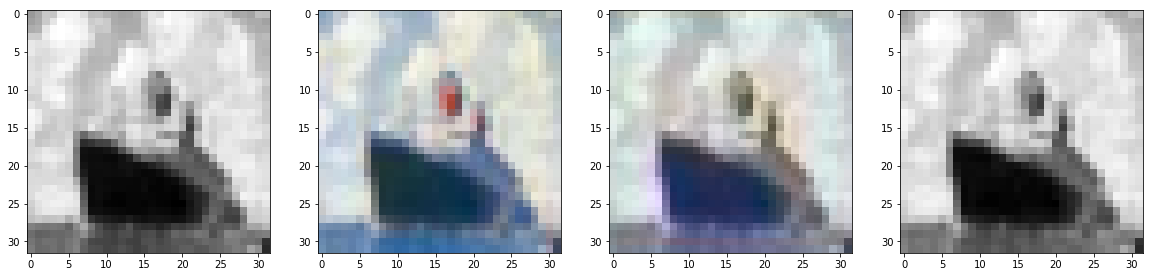

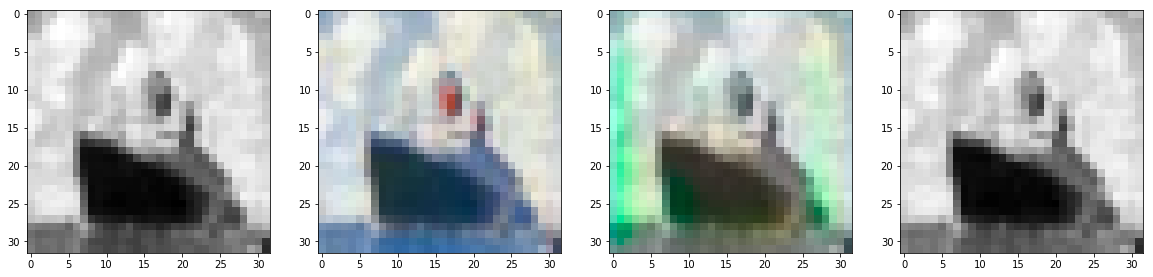

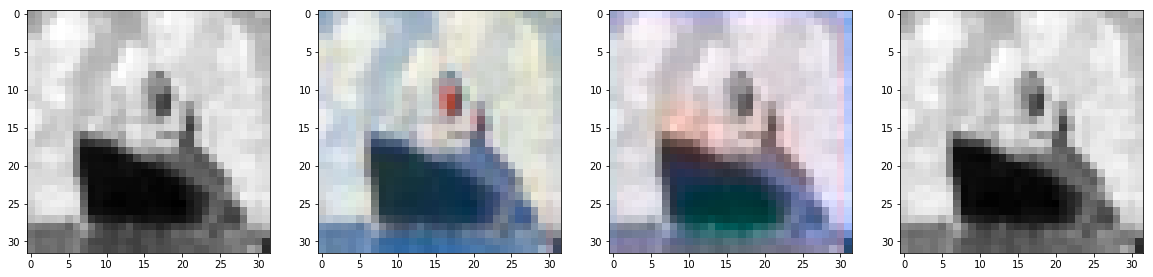

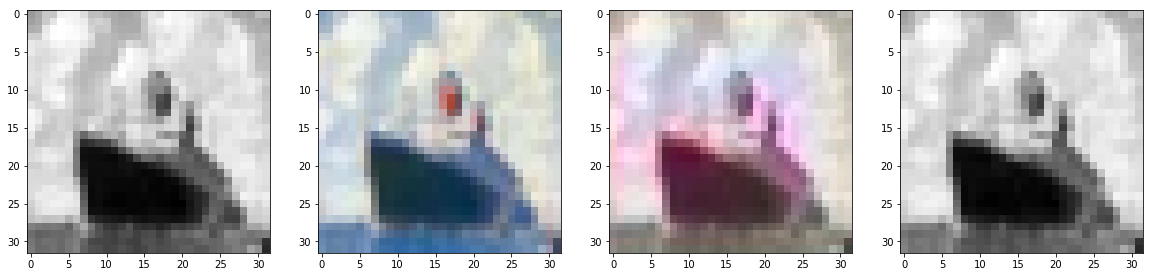

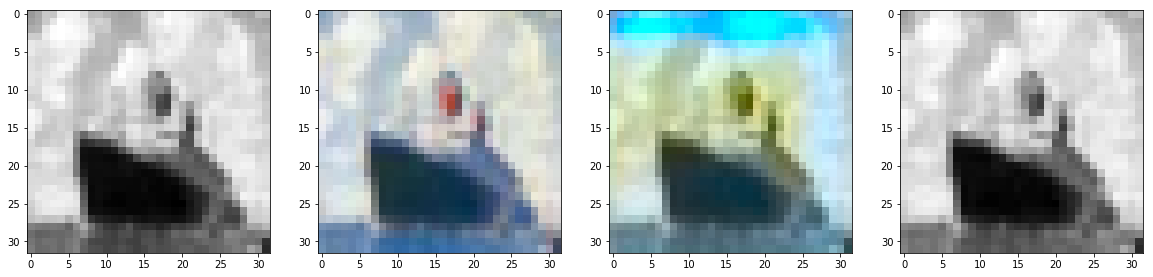

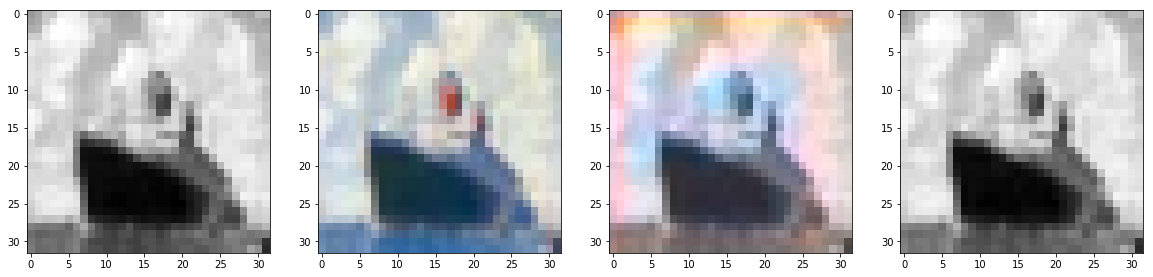

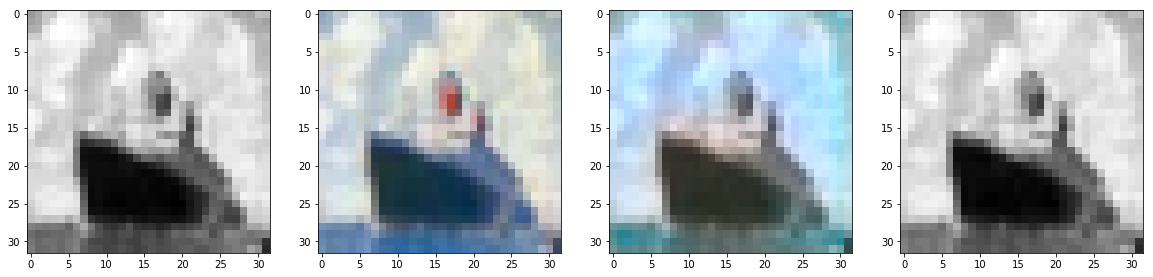

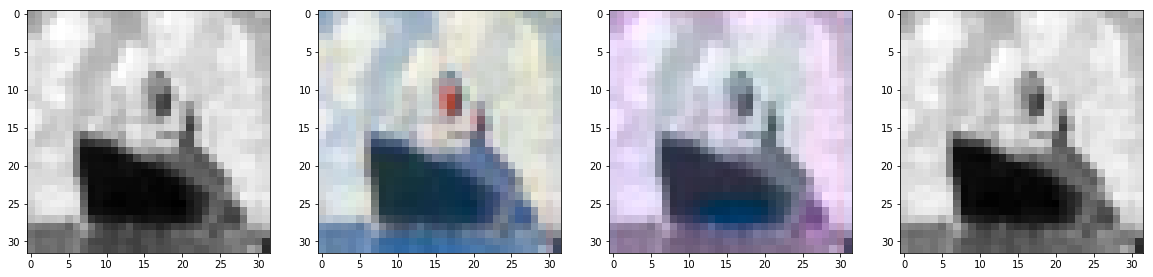

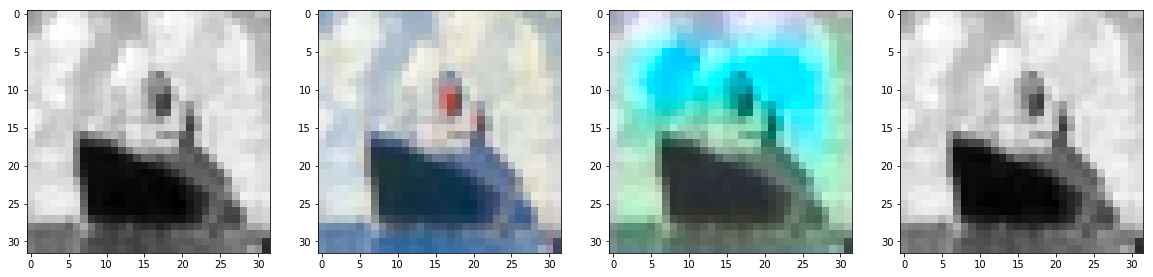

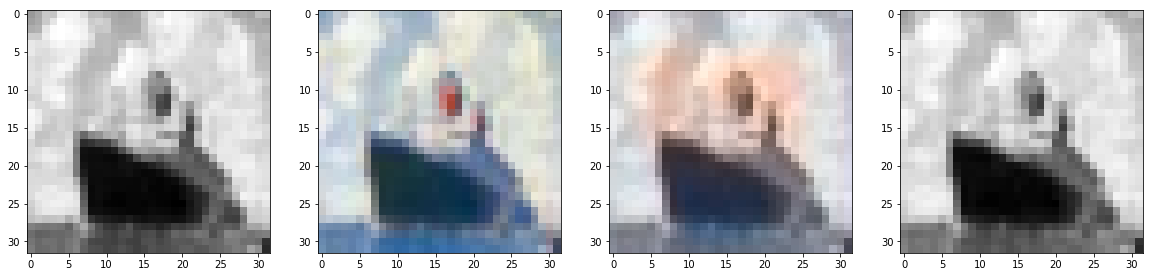

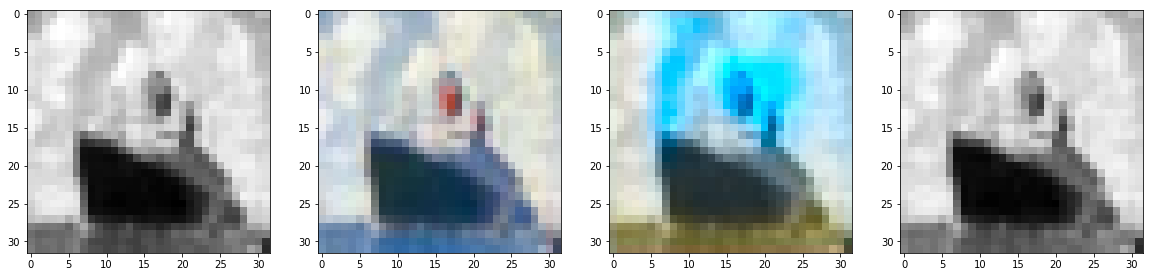

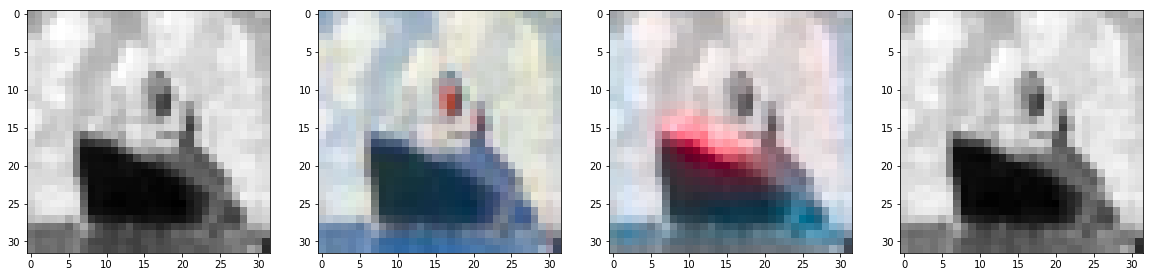

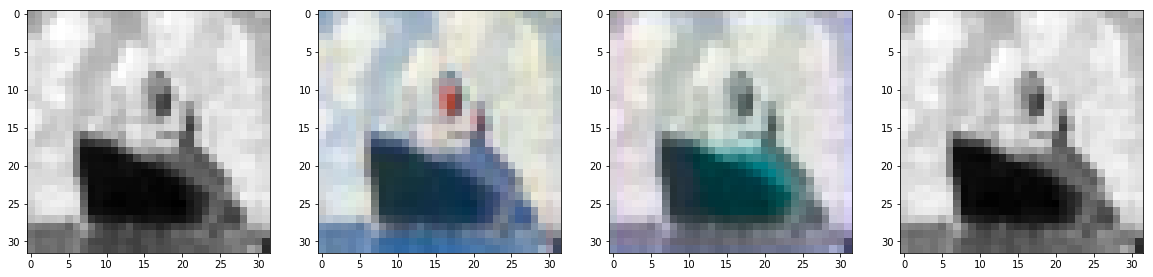

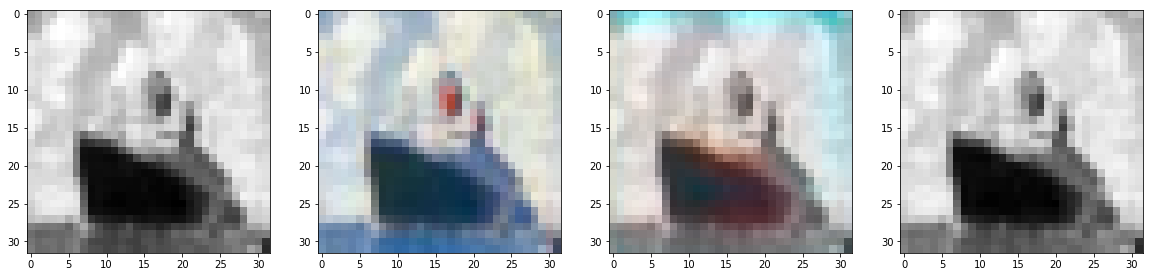

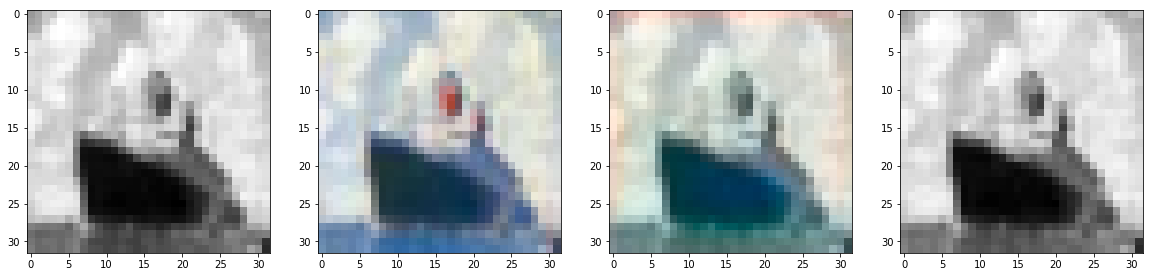

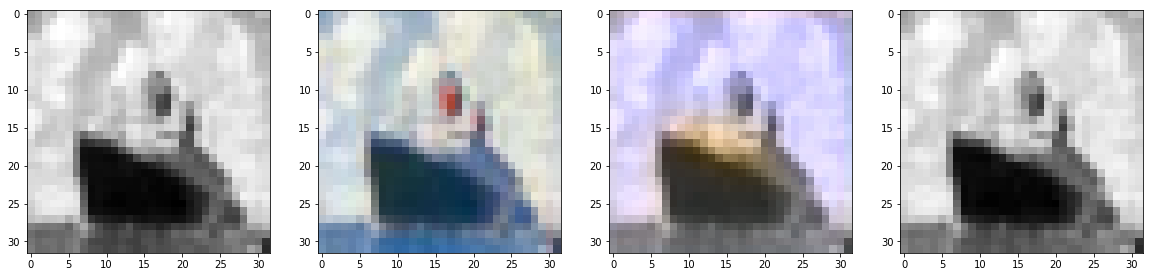

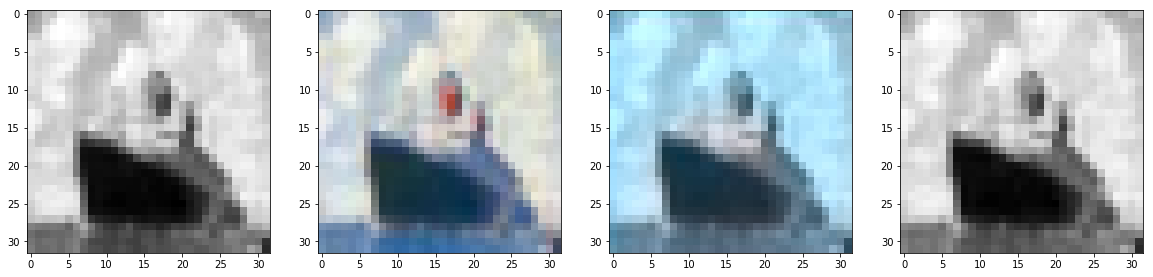

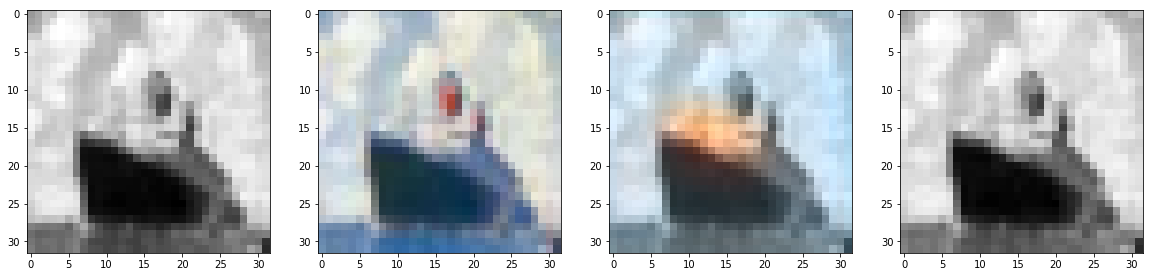

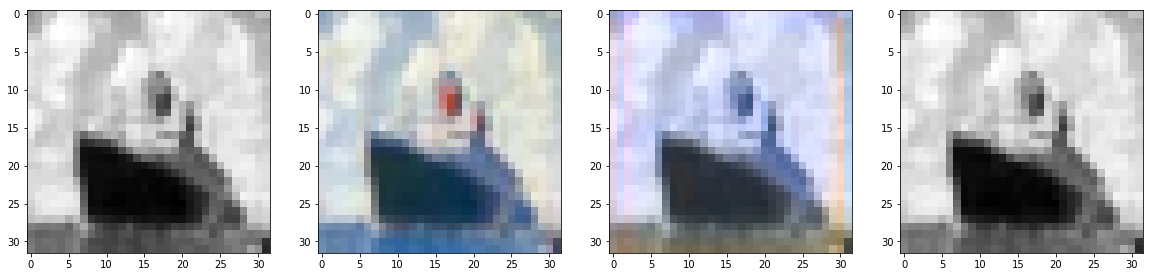

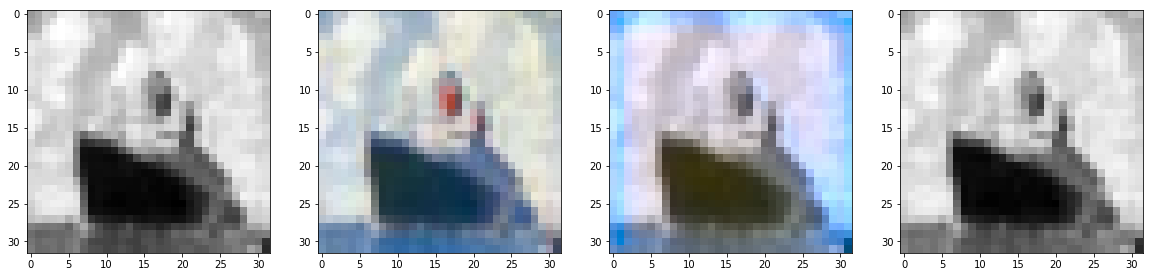

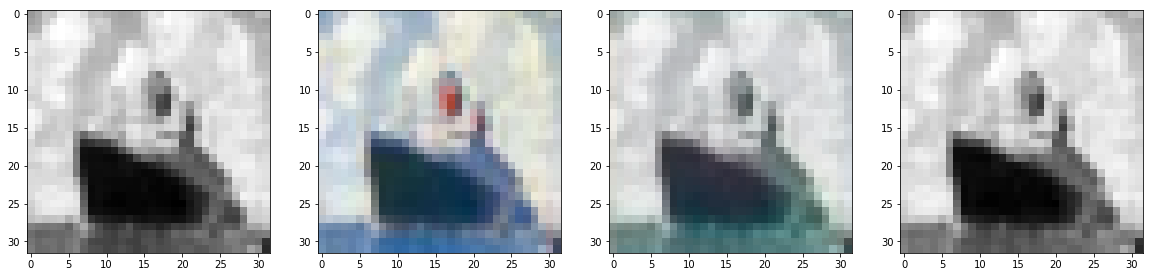

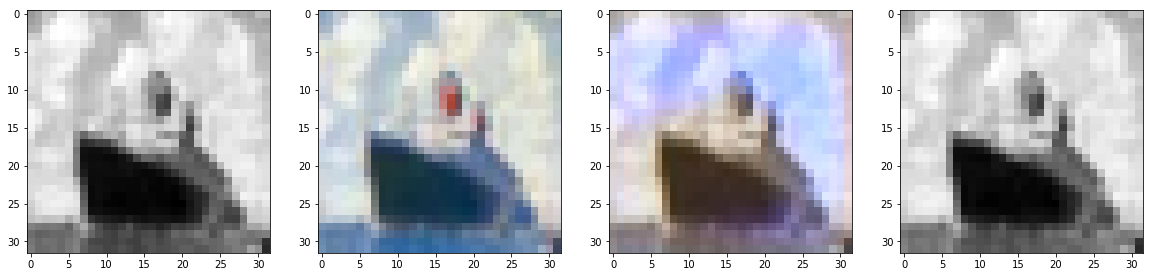

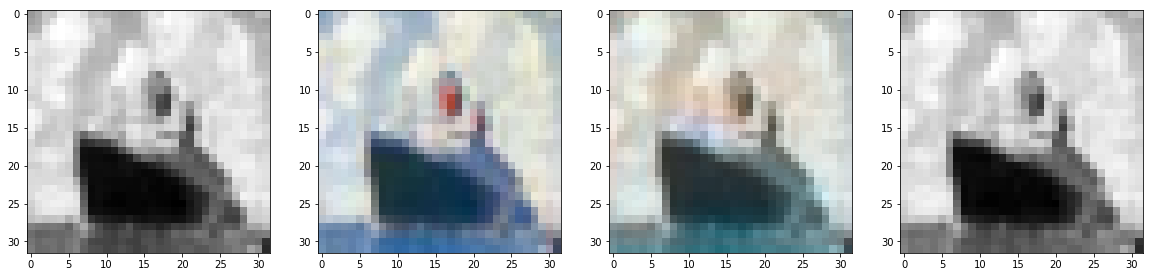

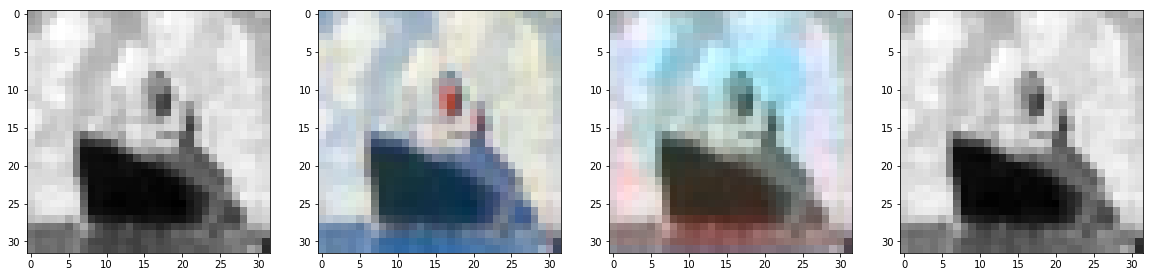

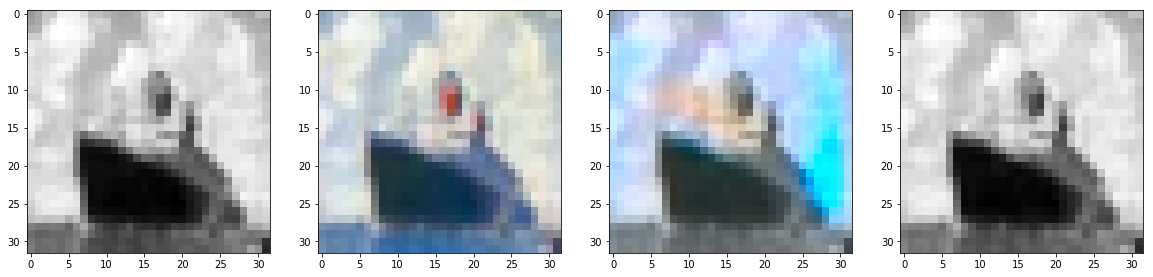

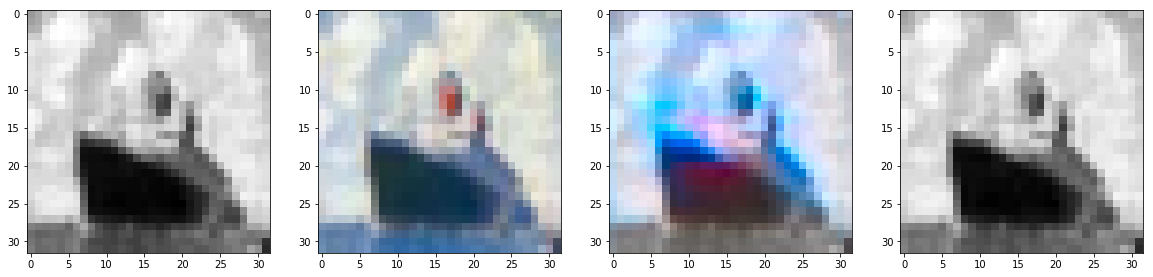

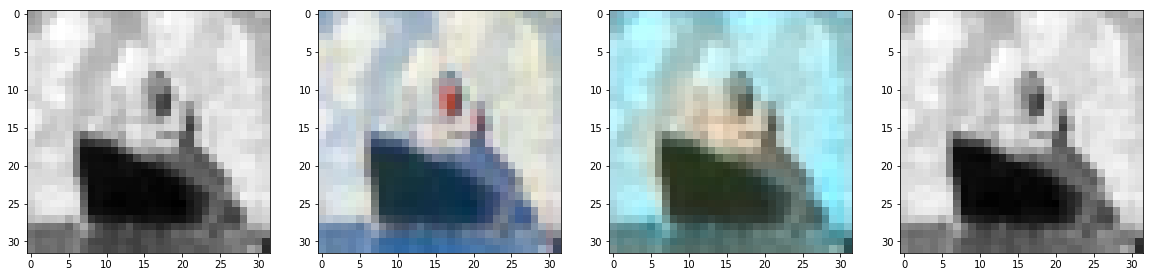

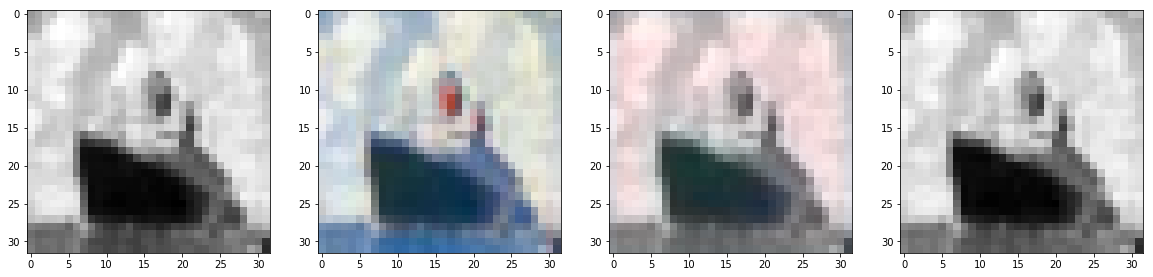

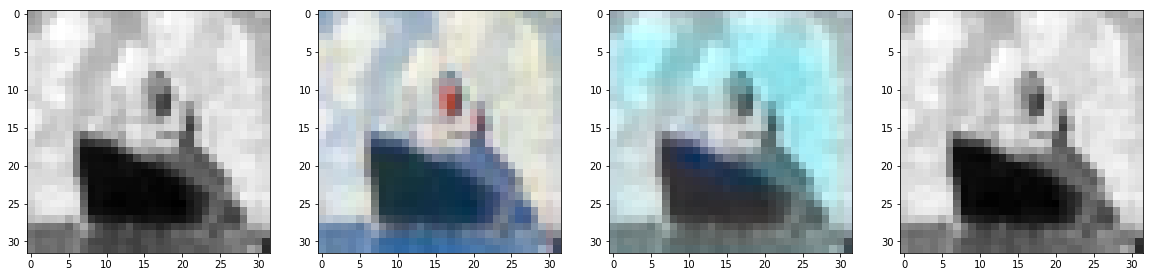

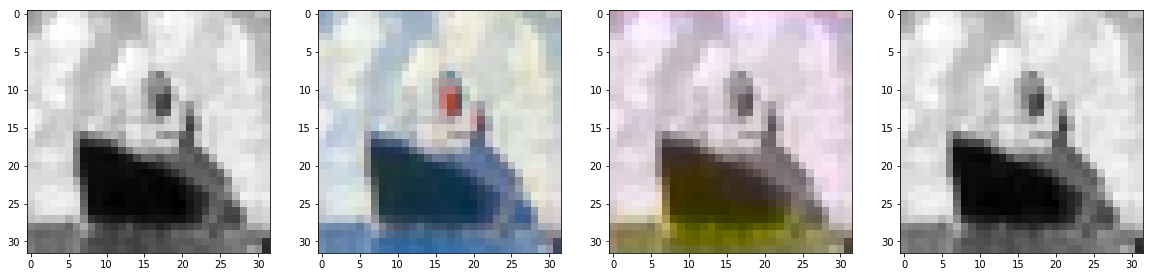

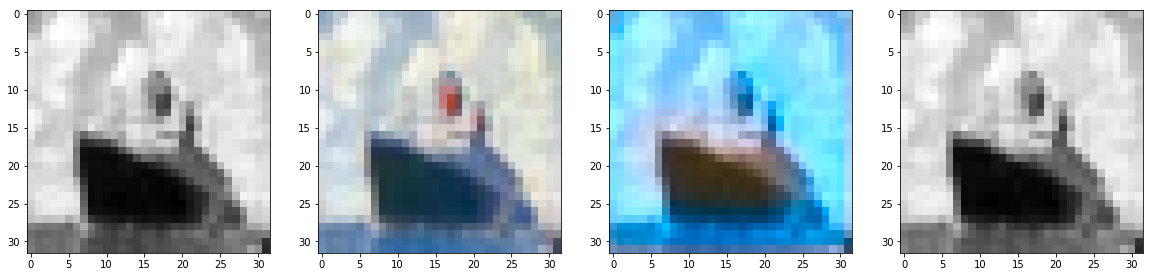

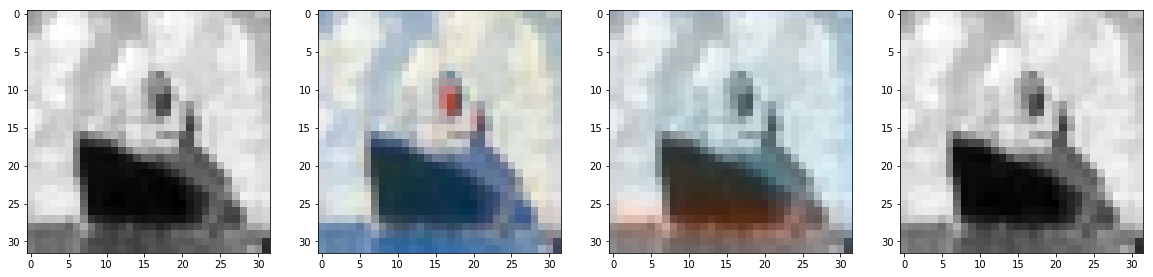

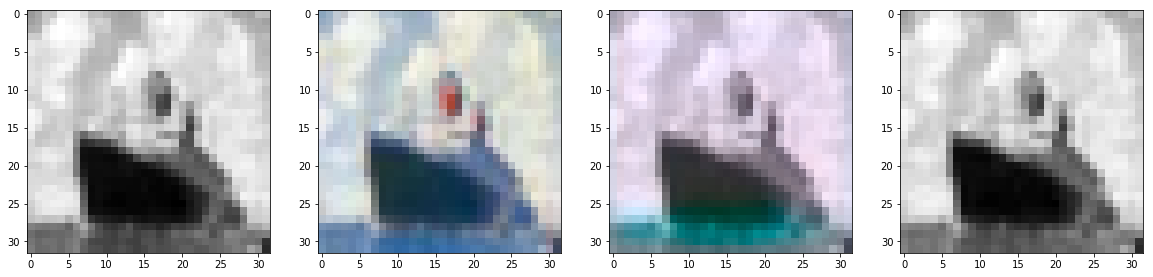

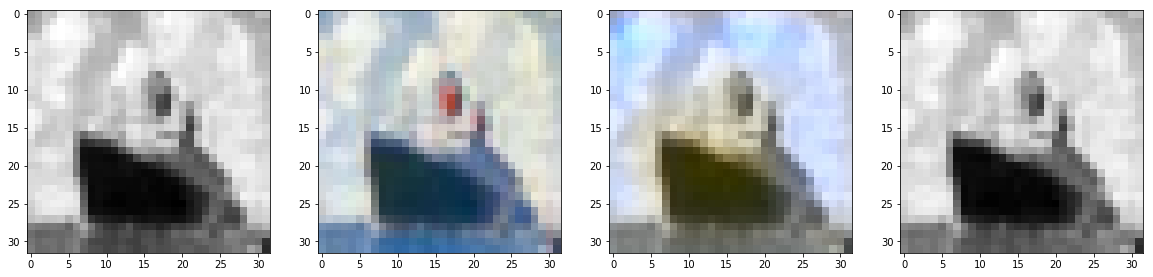

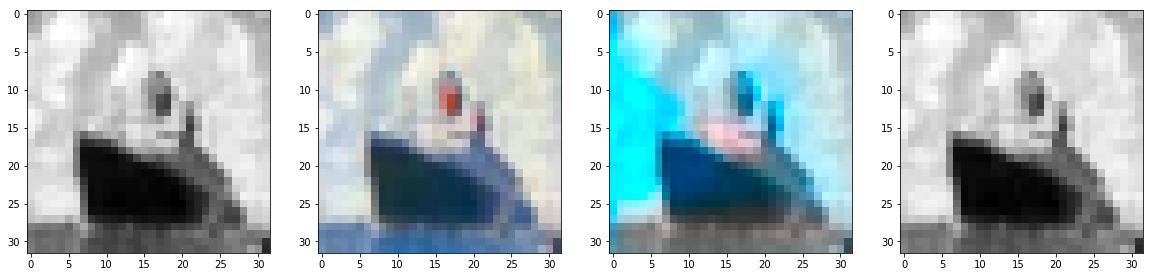

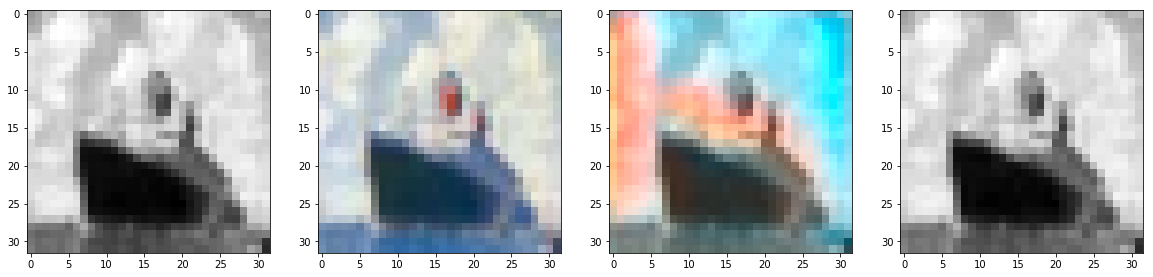

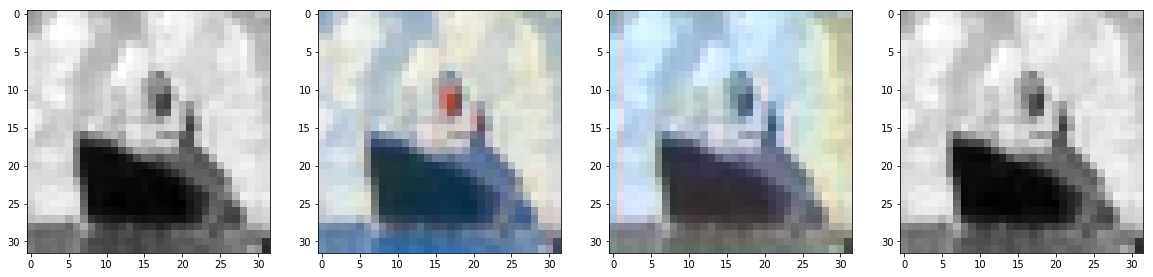

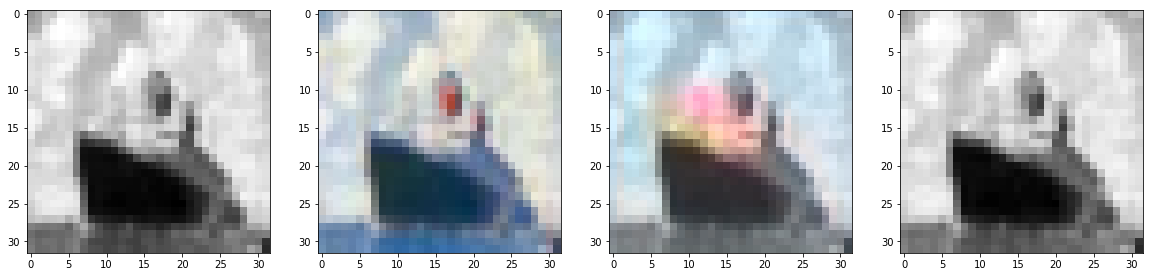

In [13]:
train_nn(75)

________________________________________________________EPOCH:  101
5000/5000 [==============================] - 106s 21ms/step
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0480 - acc: 0.9888: 1s 
Discriminator_1 ----  101
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2466 - acc: 0.9262
Discriminator_3 ----  101
d_loss: 0.24655124266128986
Epoch 1/1
5000/5000 [==============================] - 446s 89ms/step - loss: 0.2793 - acc: 0.9238
GAN ----  101
GAN Loss:  0.2793463686019182
GAN Accuracy:  0.9238
________________________________________________________EPOCH:  102
5000/5000 [==============================] - 106s 21ms/step
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1129 - acc: 0.9668
Discriminator_1 ----  102
Epoch 1/1
5000/5000 [==============================] - 12s 2ms/step - loss: 0.1025 - acc: 0.9754
Discriminator_3 ----  102
d_loss: 0.1025150138470708
Epoch 1/1
5000/5000 [======

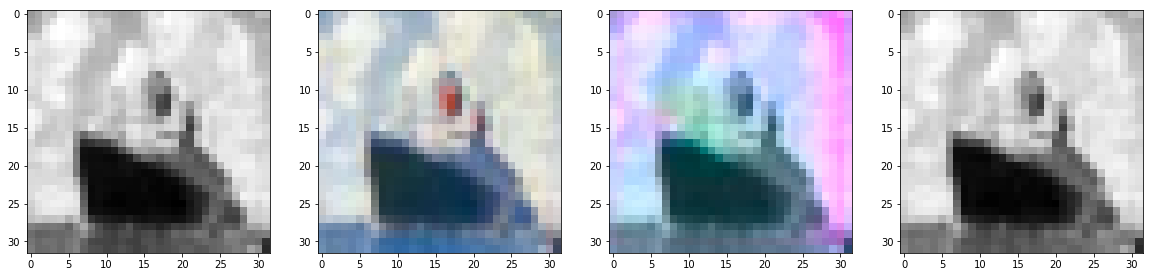

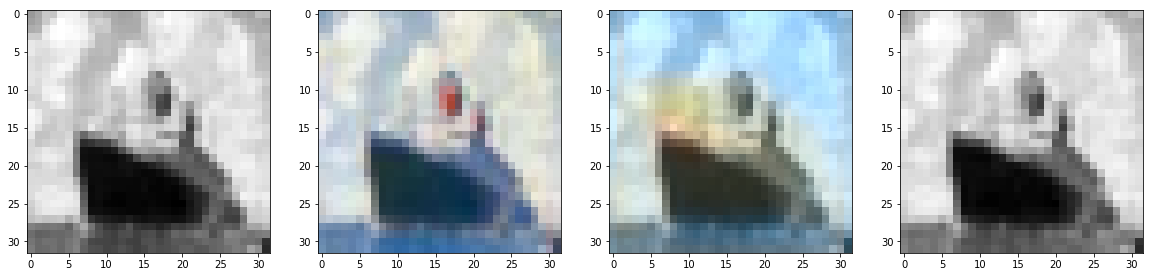

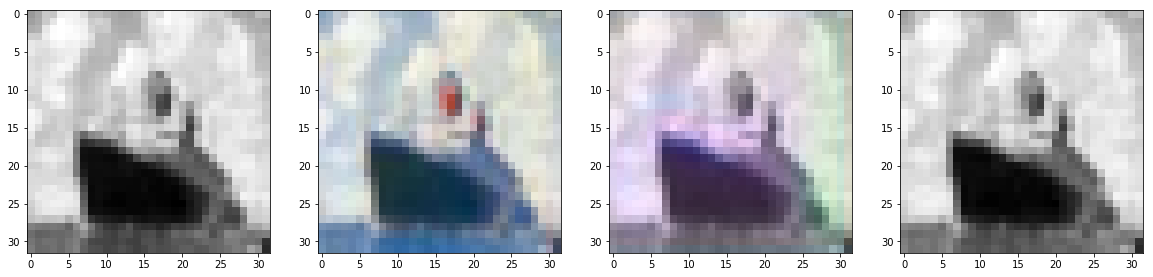

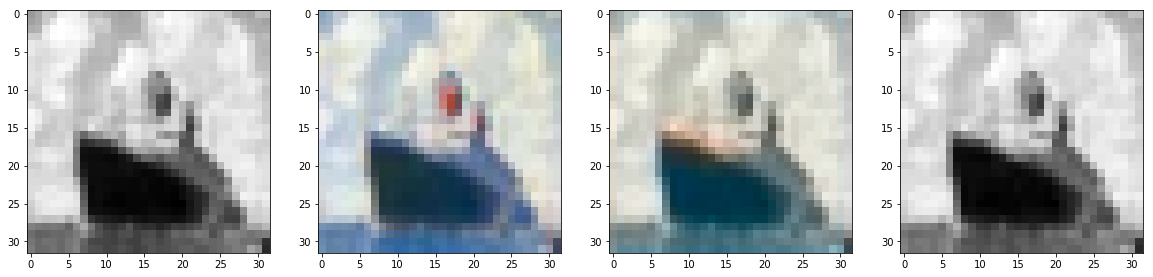

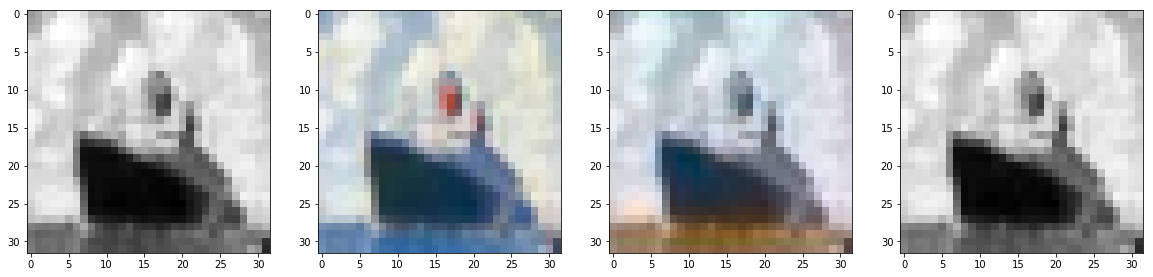

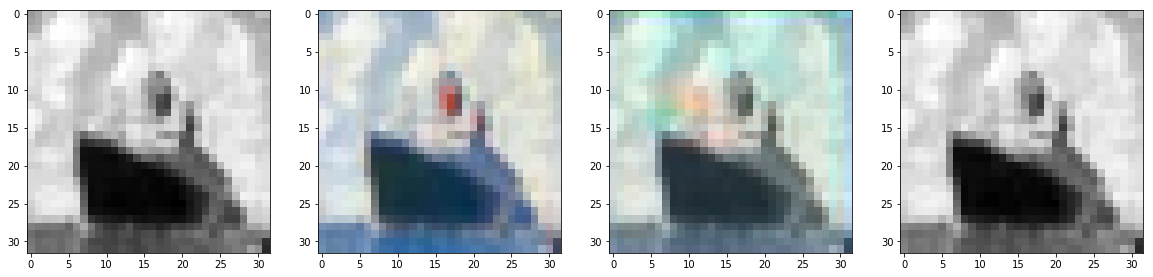

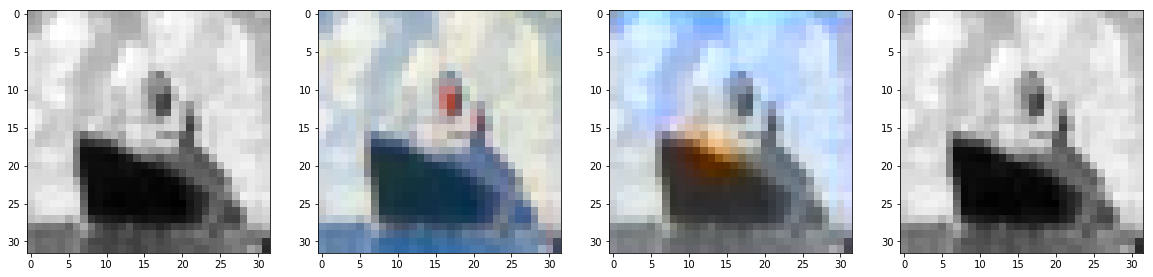

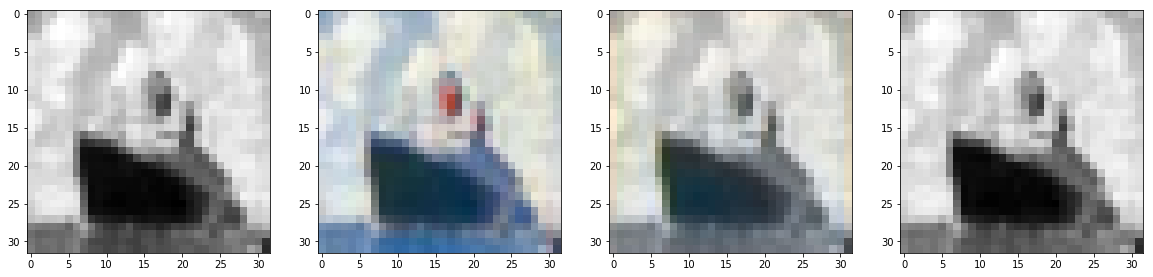

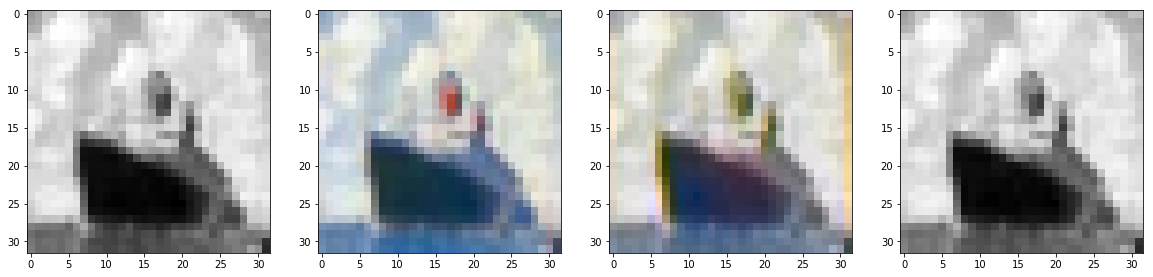

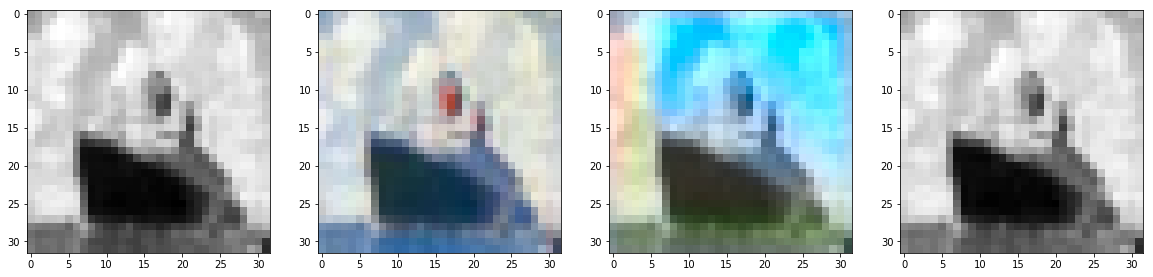

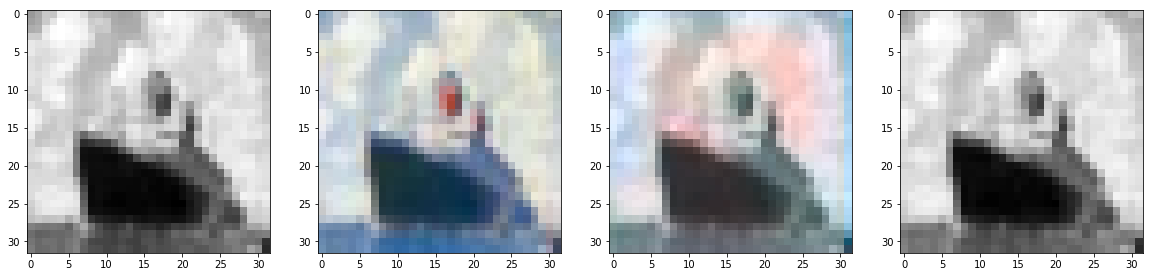

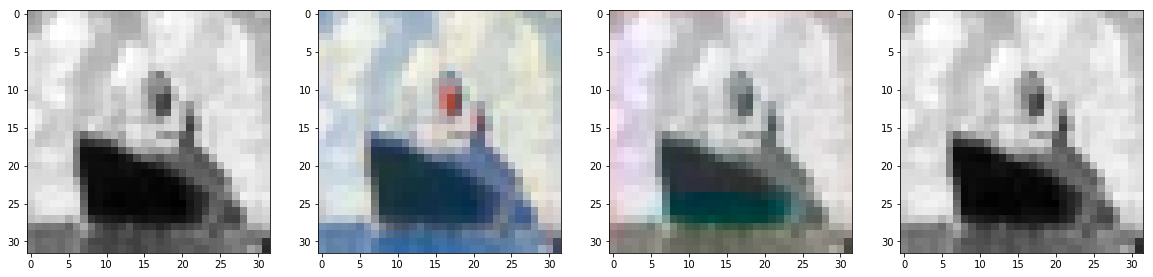

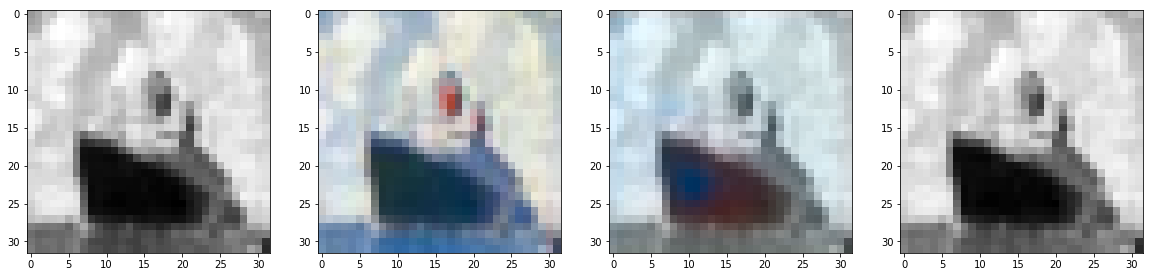

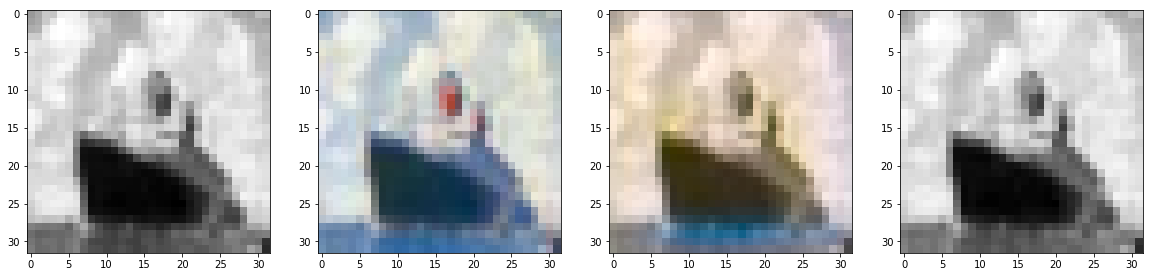

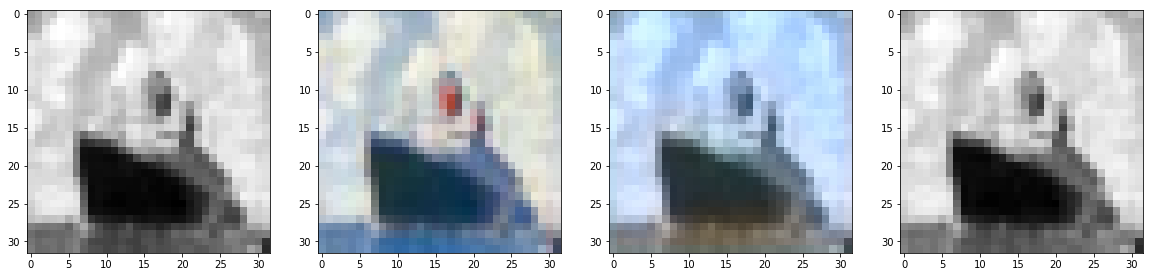

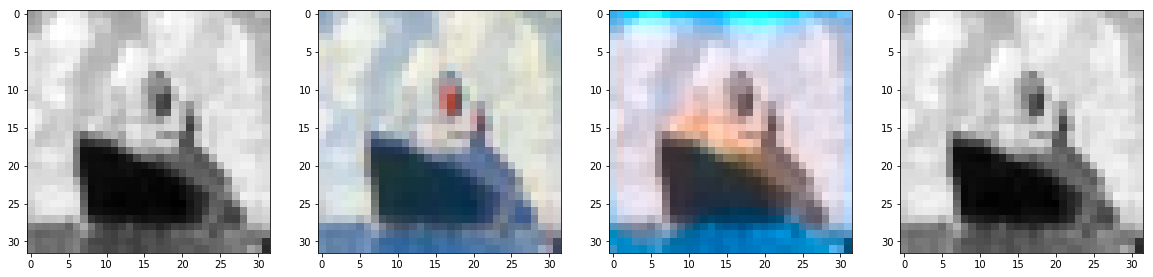

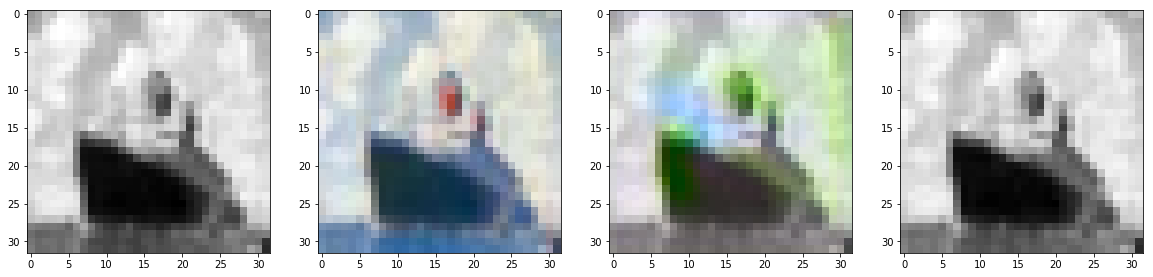

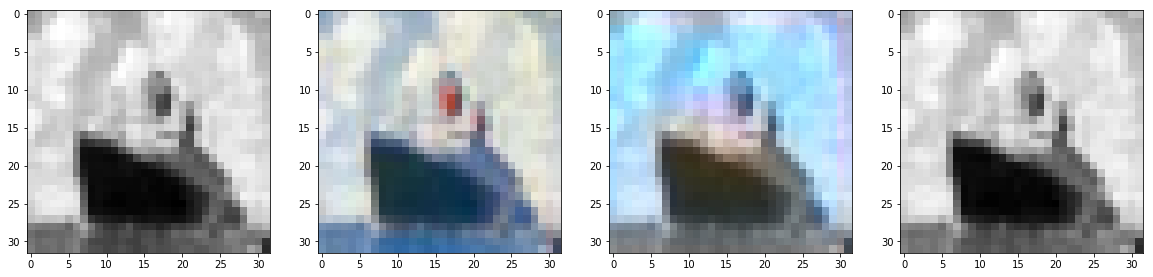

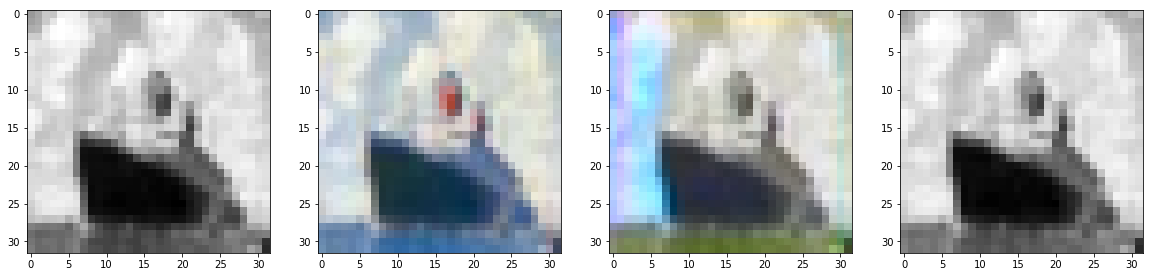

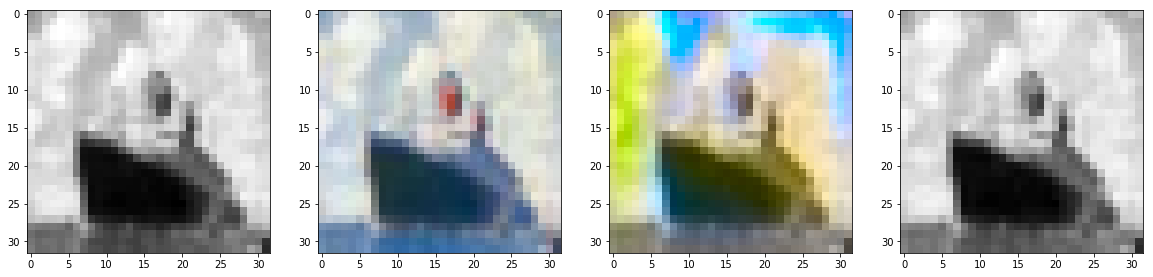

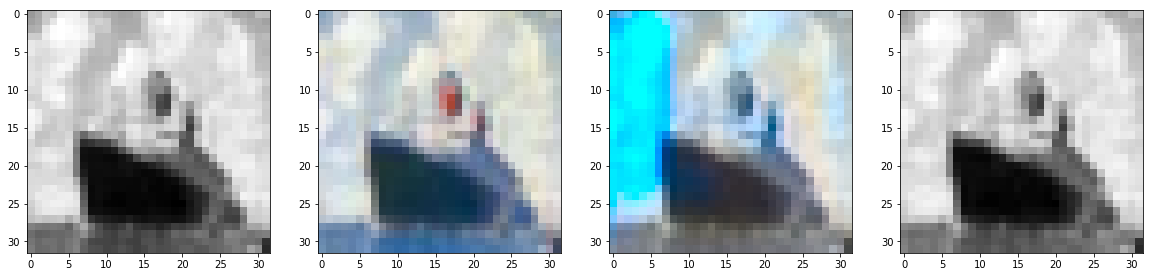

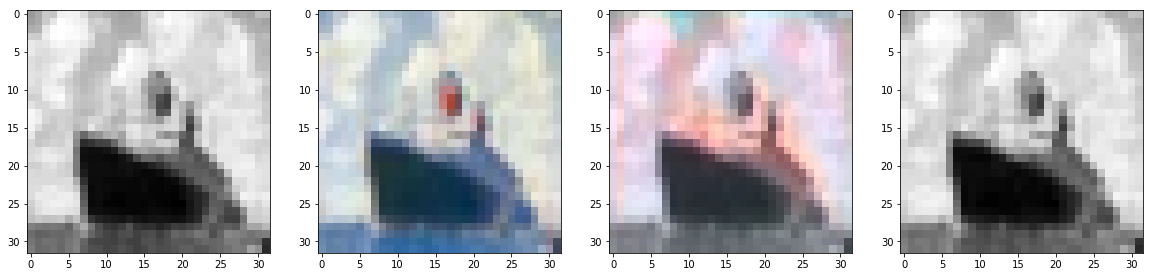

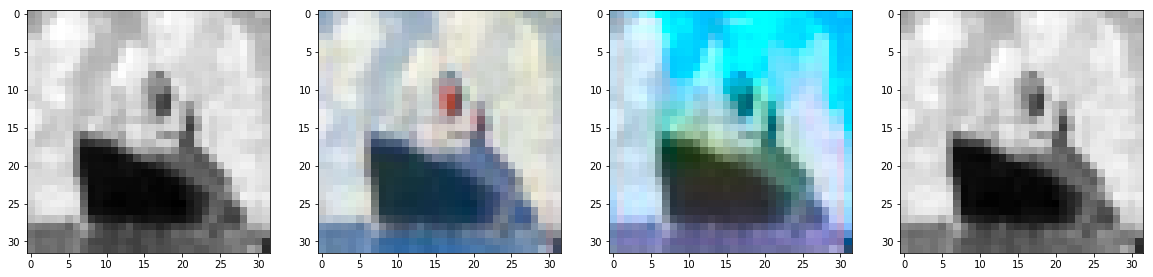

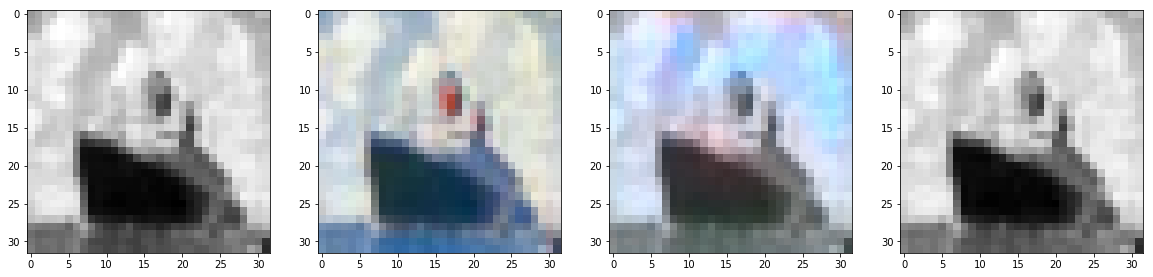

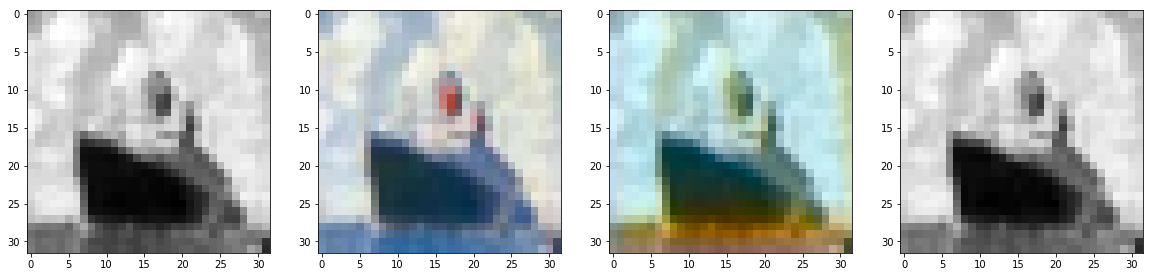

In [18]:
train_nn(25)

________________________________________________________EPOCH:  126
5000/5000 [==============================] - 81s 16ms/step
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0951 - acc: 0.9658
Discriminator_1 ----  126
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.0949 - acc: 0.9746
Discriminator_3 ----  126
d_loss: 0.09493276775568957
Epoch 1/1
5000/5000 [==============================] - 305s 61ms/step - loss: 0.2009 - acc: 0.9718
GAN ----  126
GAN Loss:  0.20088083105087282
GAN Accuracy:  0.9718
________________________________________________________EPOCH:  127
5000/5000 [==============================] - 78s 16ms/step
Epoch 1/1
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0309 - acc: 0.9958
Discriminator_1 ----  127
Epoch 1/1
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2587 - acc: 0.9222
Discriminator_3 ----  127
d_loss: 0.258669117465755
Epoch 1/1
5000/5000 [=================

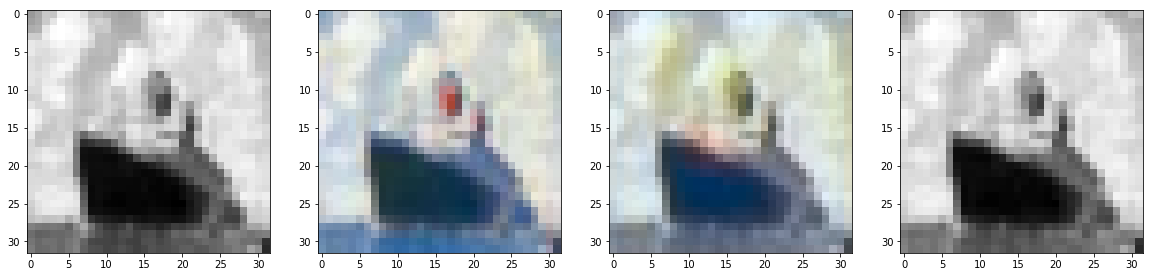

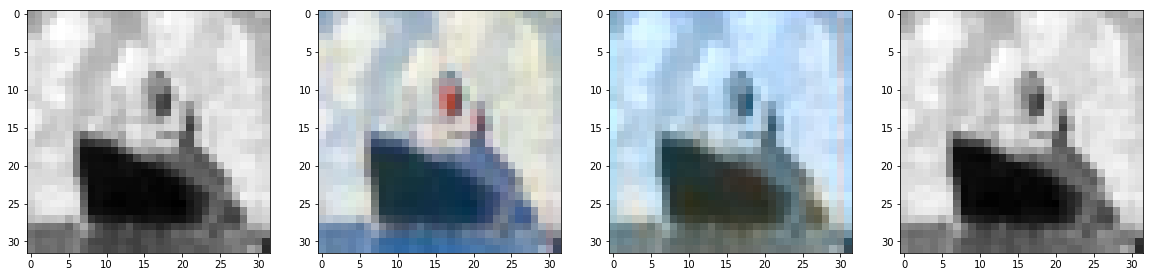

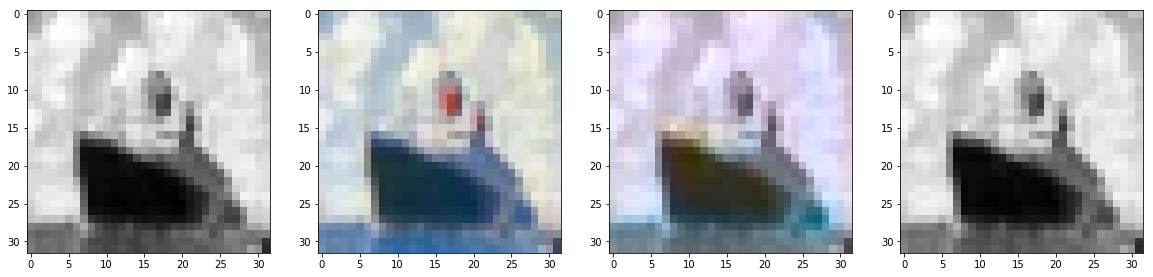

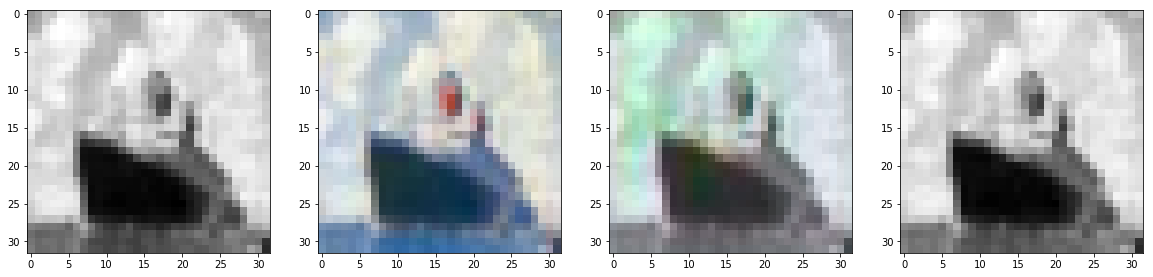

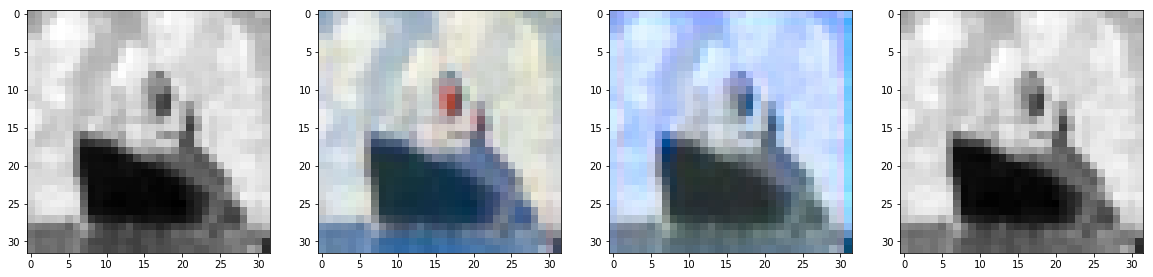

In [23]:
train_nn(5)

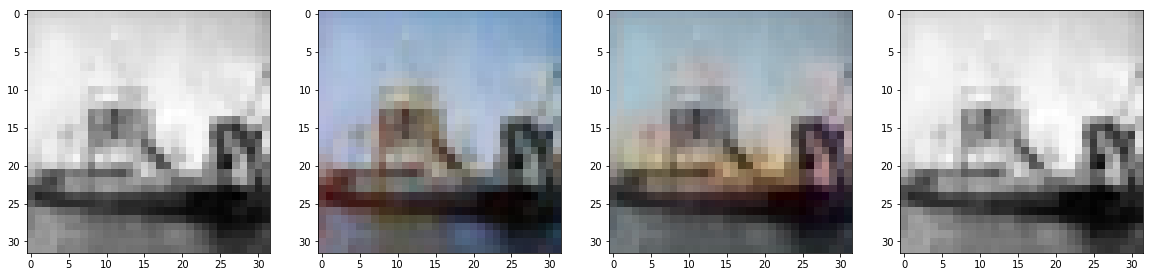

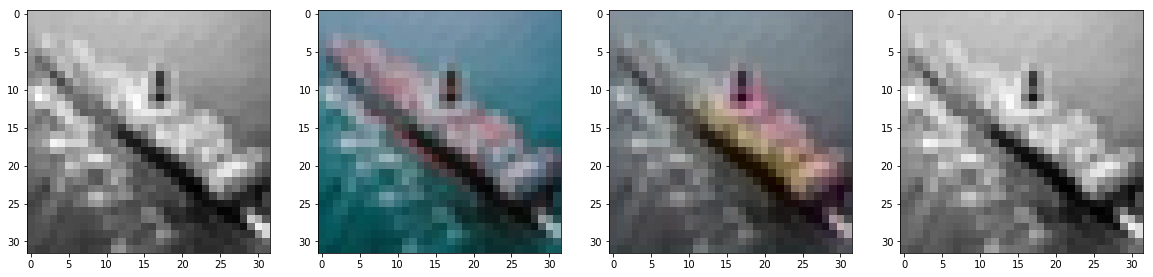

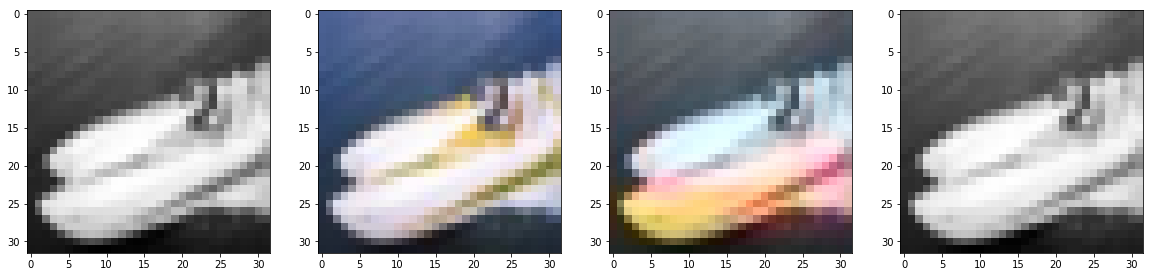

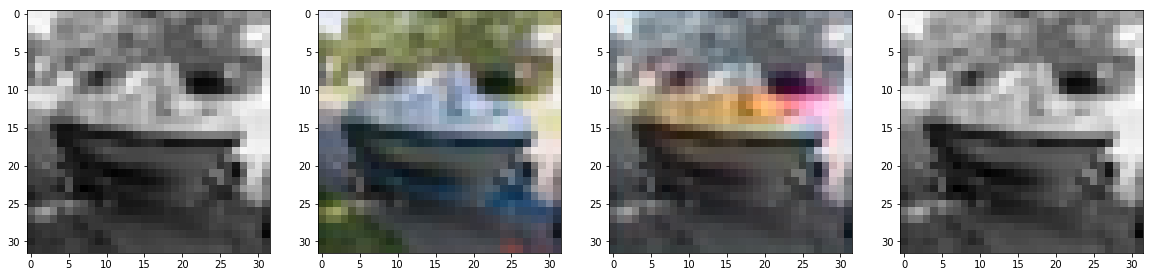

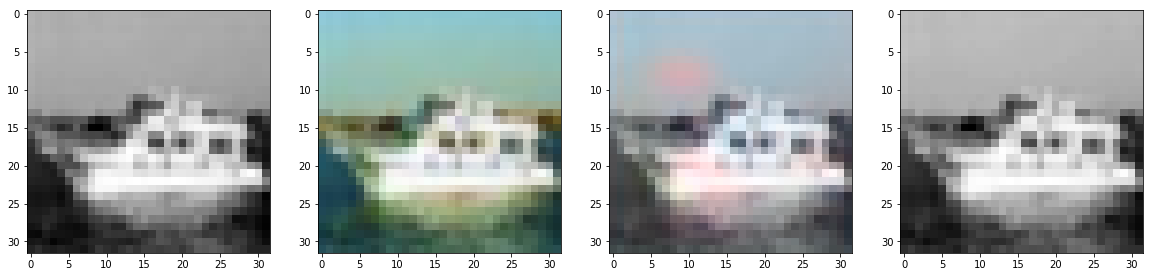

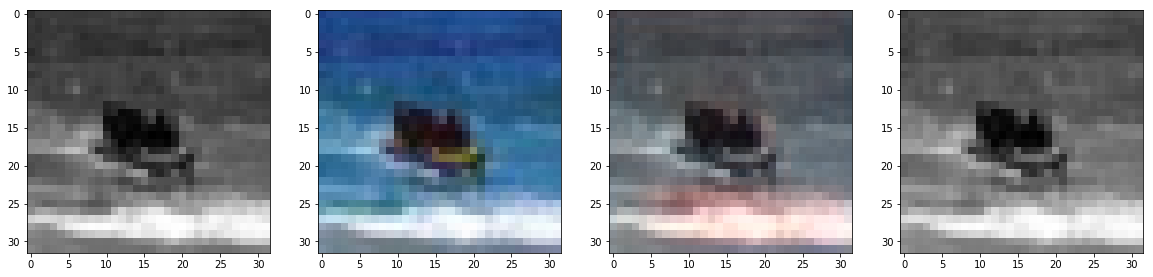

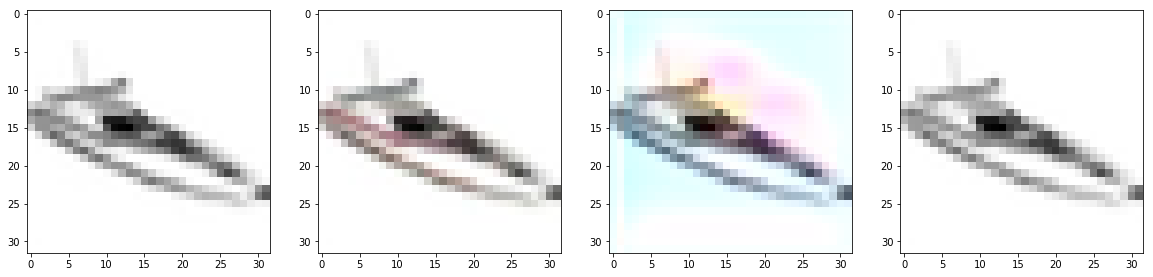

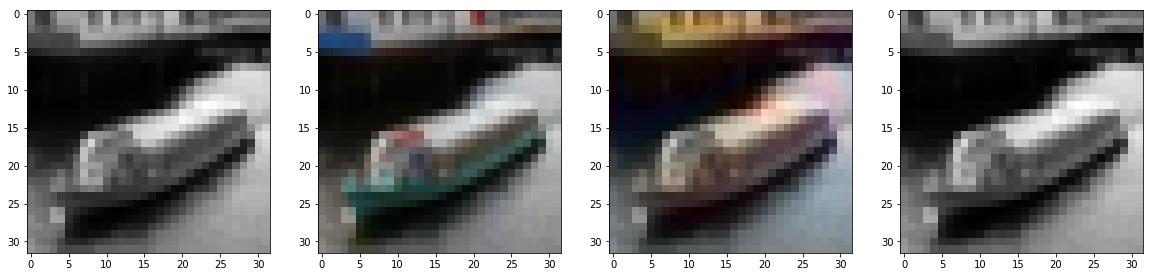

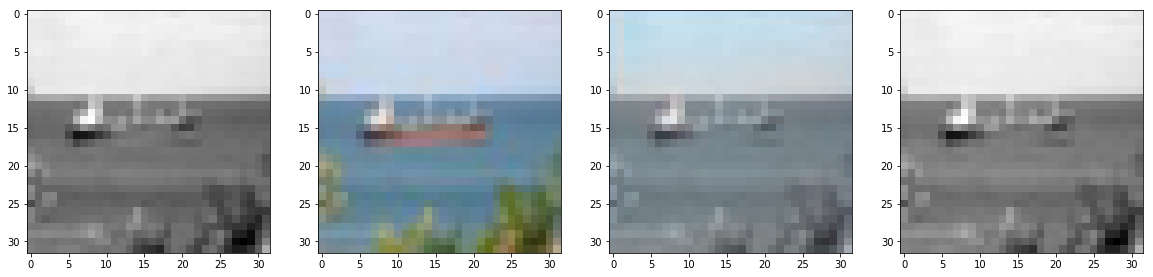

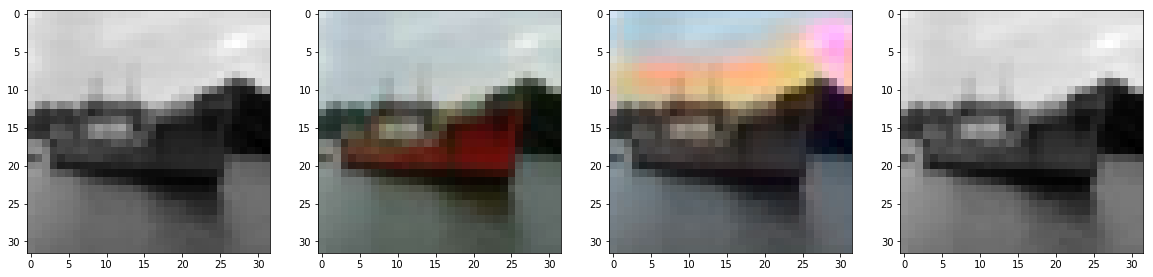

In [17]:
#Result after 100 epochs
v=4
for i in range (v*10,v*10+10):
    view_result(i)

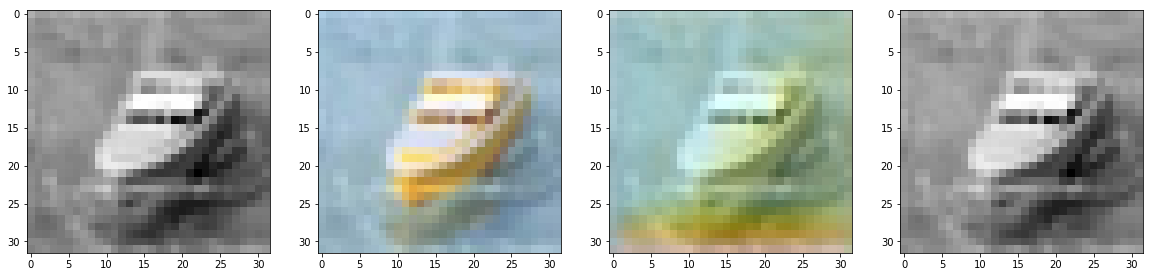

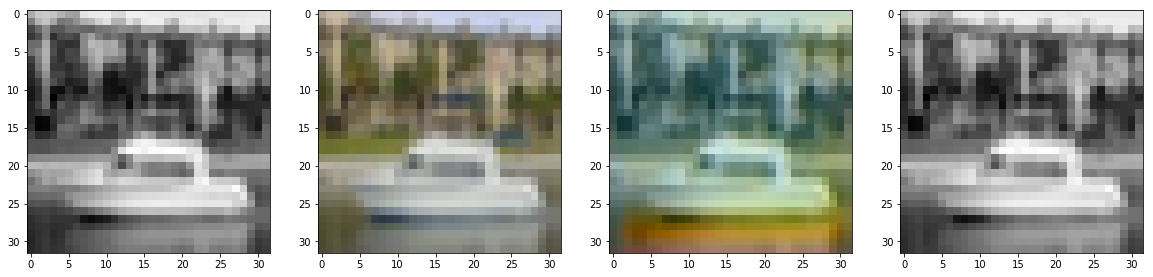

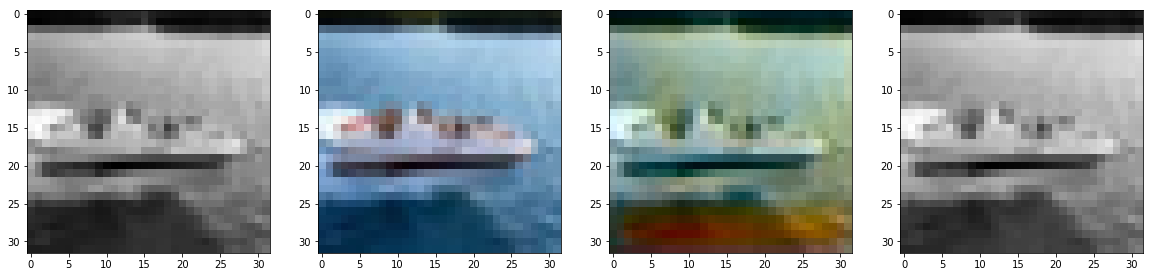

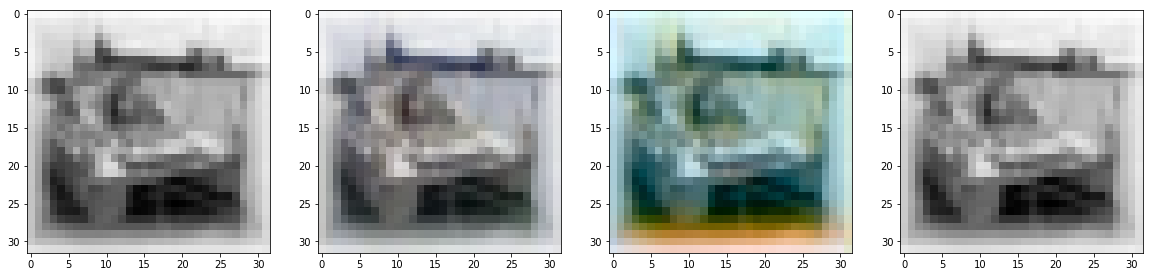

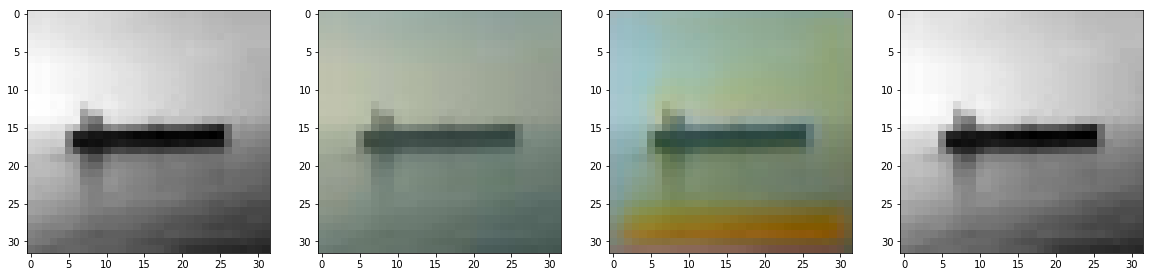

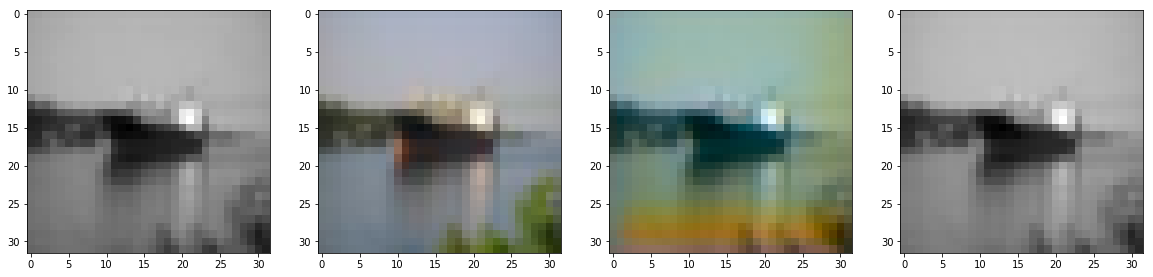

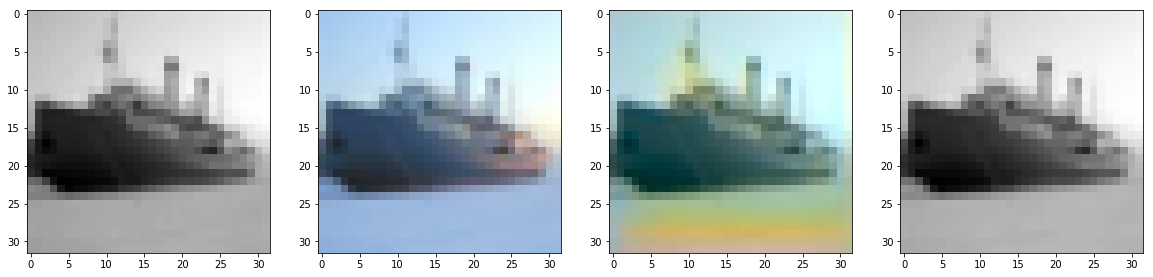

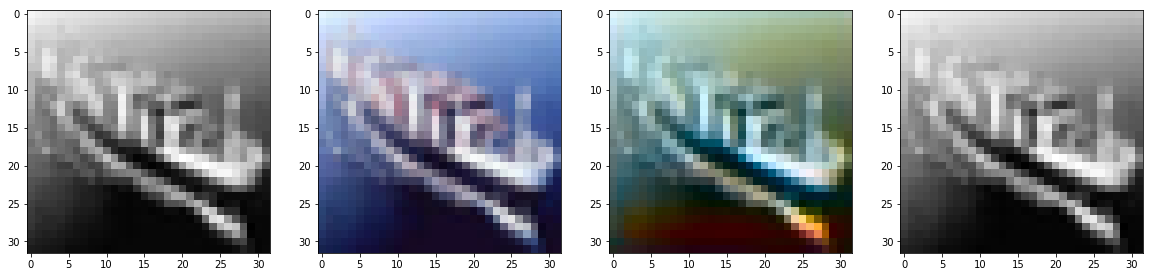

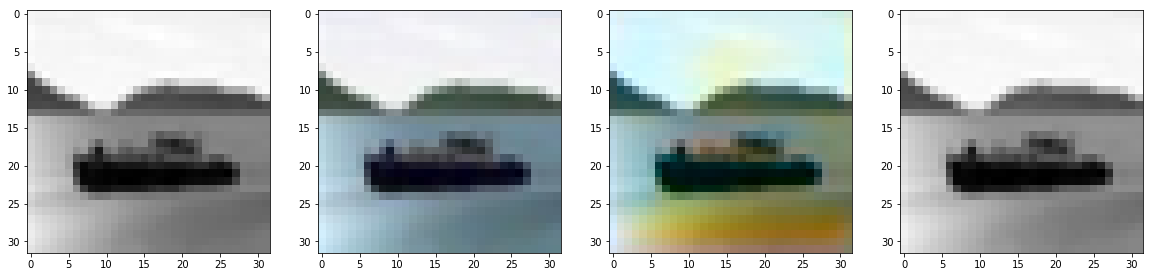

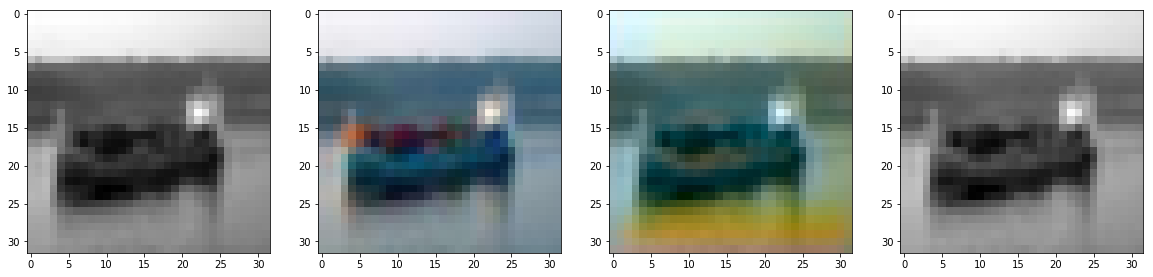

In [22]:
#Result after 125 epochs
v=5
for i in range (v*10,v*10+10):
    view_result(i)

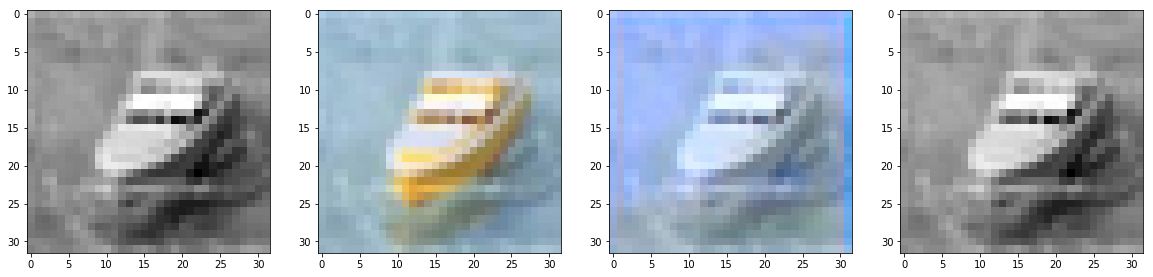

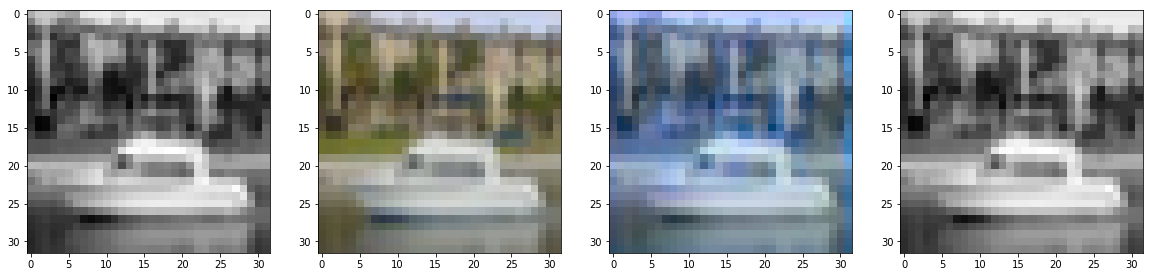

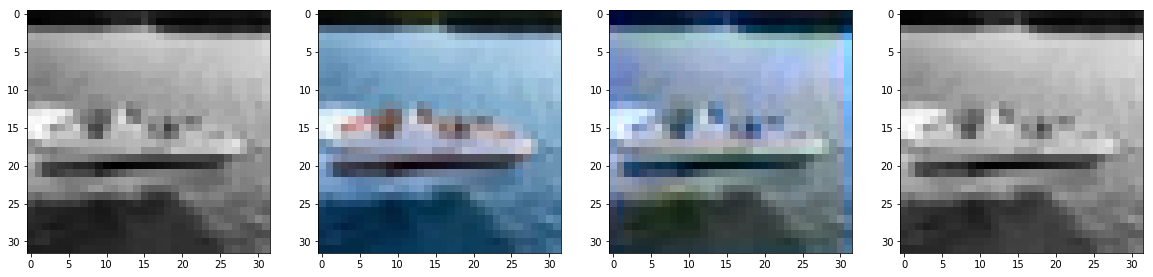

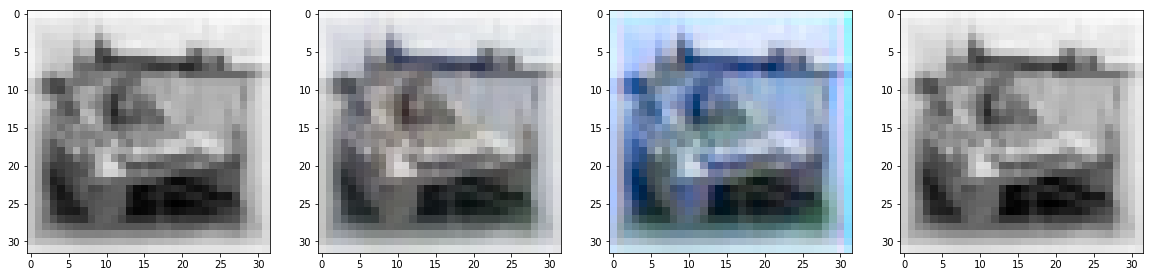

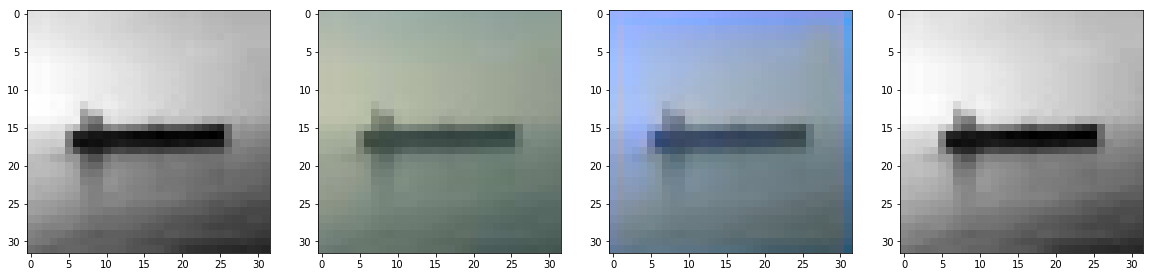

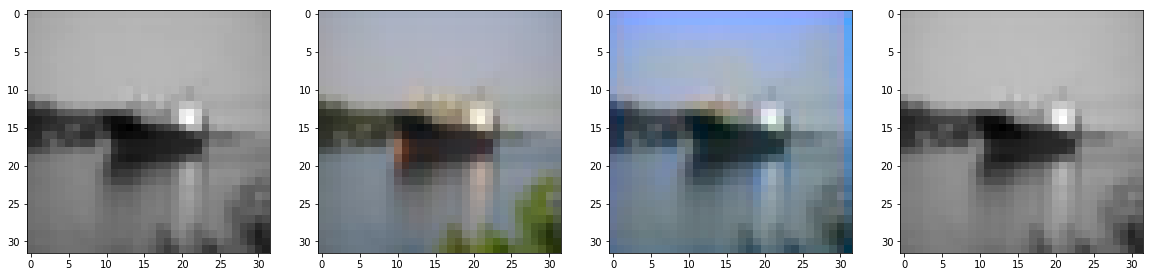

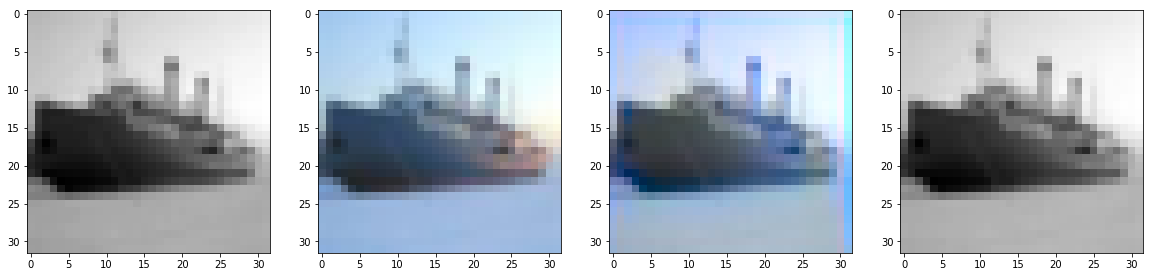

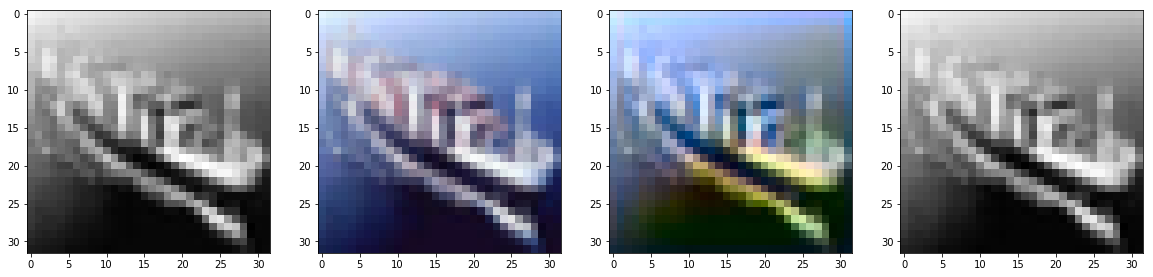

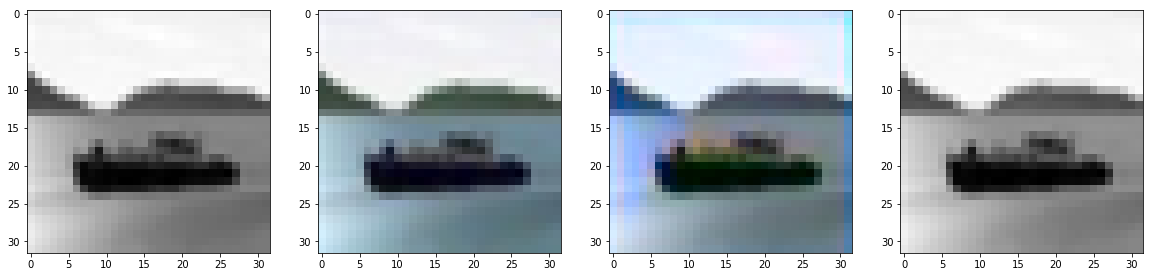

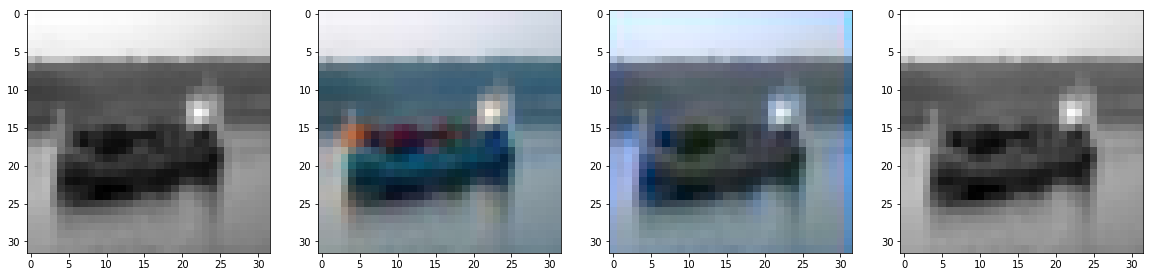

In [25]:
#Result after 130 epochs
v=5
for i in range (v*10,v*10+10):
    view_result(i)

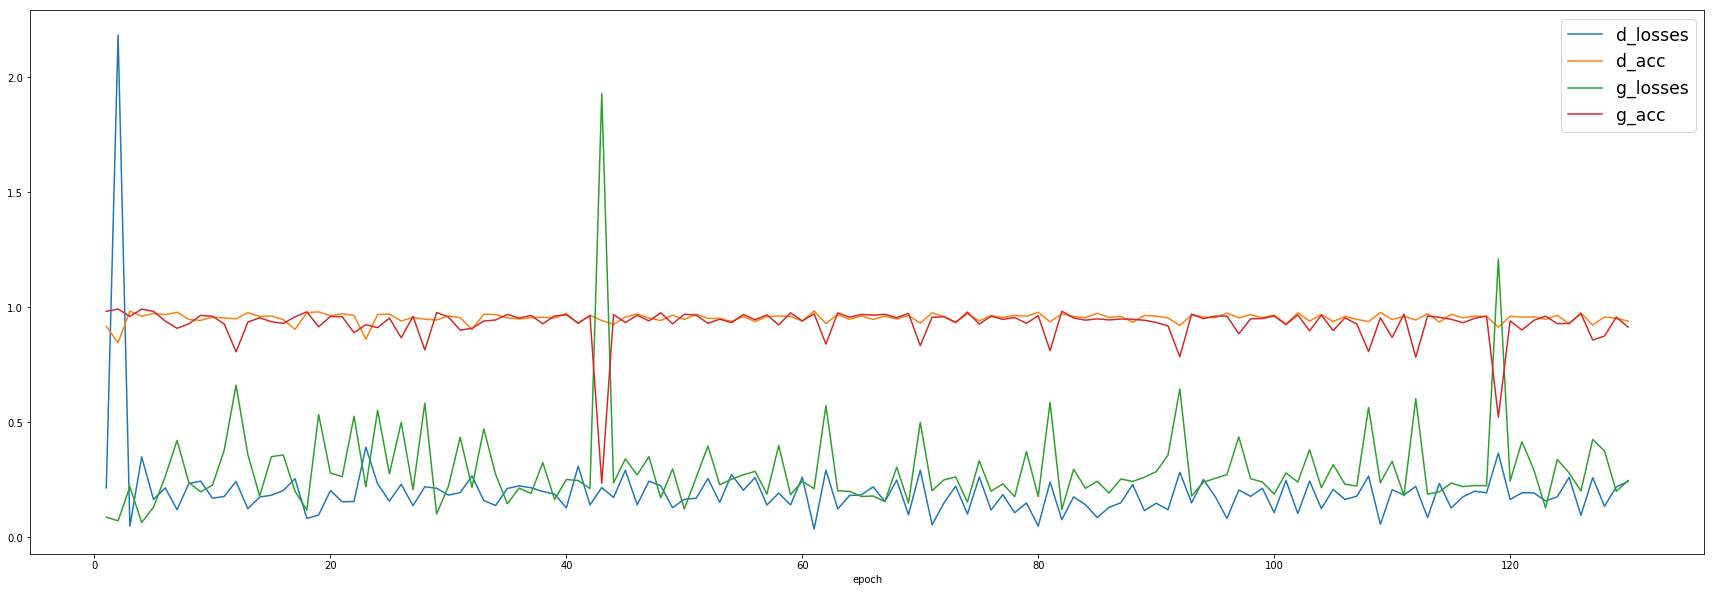

In [28]:
"""
Plot model history
"""
x11=np.arange(1,count)
plt.figure(figsize=(30,10))
plt.plot(x11,d_losses)
plt.plot(x11,d_acc)
plt.plot(x11,g_losses)
plt.plot(x11,g_acc)

plt.xlabel('epoch')
plt.legend(['d_losses', 'd_acc','g_losses','g_acc'], loc='upper right',fontsize='xx-large')

In [29]:
"""
Save models and their respective history.
"""

generator.save('g_final_ship.h5')
discriminator.save('d_final_ship.h5')
gan.save('gan_final_ship.h5')
np.savetxt('d_final_ship_losses.txt',np.array(d_losses), fmt='%f')
np.savetxt('d_final_ship_acc.txt',np.array(d_acc), fmt='%f')
np.savetxt('g_final_ship_losses.txt',np.array(g_losses), fmt='%f')
np.savetxt('g_final_ship_acc.txt',np.array(g_acc), fmt='%f')


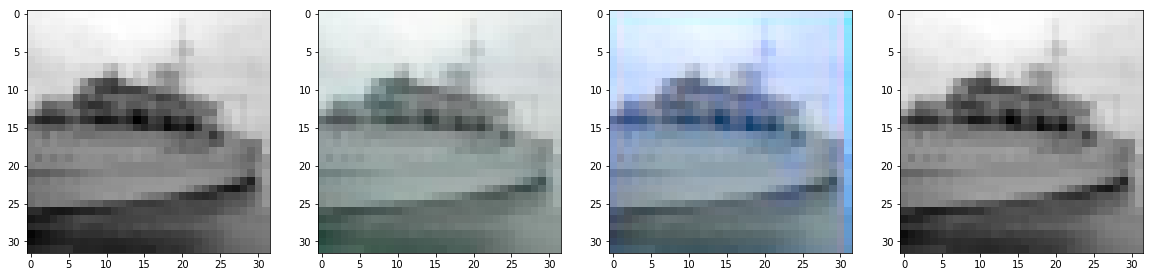

In [37]:
"""
(Commented section.Uncomment to use!)

#Load model for future use:

from keras.models import load_model
g_test = load_model('g_final_ship.h5')
view_result(10)


#Load history of generator and discriminator models:

d_losses = np.loadtxt('d_final_ship_losses.txt', dtype=float)
d_acc = np.loadtxt('d_final_ship_acc.txt', dtype=float)
g_acc = np.loadtxt('g_final_ship_acc.txt', dtype=float)
g_losses = np.loadtxt('d_final_ship_losses.txt', dtype=float)
"""

